
# Airline Passenger Satisfaction

Basic imports

In [1528]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

%matplotlib inline


Initilize constants.
- categorical_columns = columns where the value is categorical 
- columns_to_scale = columns where the values are way different than the rest (in comparation to rating columns for example)
- ratings_col = columns with rating 1-5

In [1345]:
train_path = 'train.csv'
test_path = 'test.csv'

categorical_columns = [
    'Gender','Customer Type',
    'Type of Travel','Class' 
    ]

columns_to_scale = [
    'Arrival Delay in Minutes',
    'Departure Delay in Minutes',
    'Flight Distance',
    'Age'
    ]

rating_columns = [ "Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", 
"Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service", 
                    "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness"]

target_column = 'satisfaction'

In [1095]:
df_train = pd.read_csv(train_path)
df_test= pd.read_csv(test_path)

**Visualization**

Lets take a sneak peak over the train data

In [680]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [681]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

Our data contains 22 features that vary between numerical values, categorical values, and features that represent ratings between 1 to 5.
Based on those features we have to predict the satisfaction of the passengers.

First let's see how much our data is correlated using a corrleation matrix 

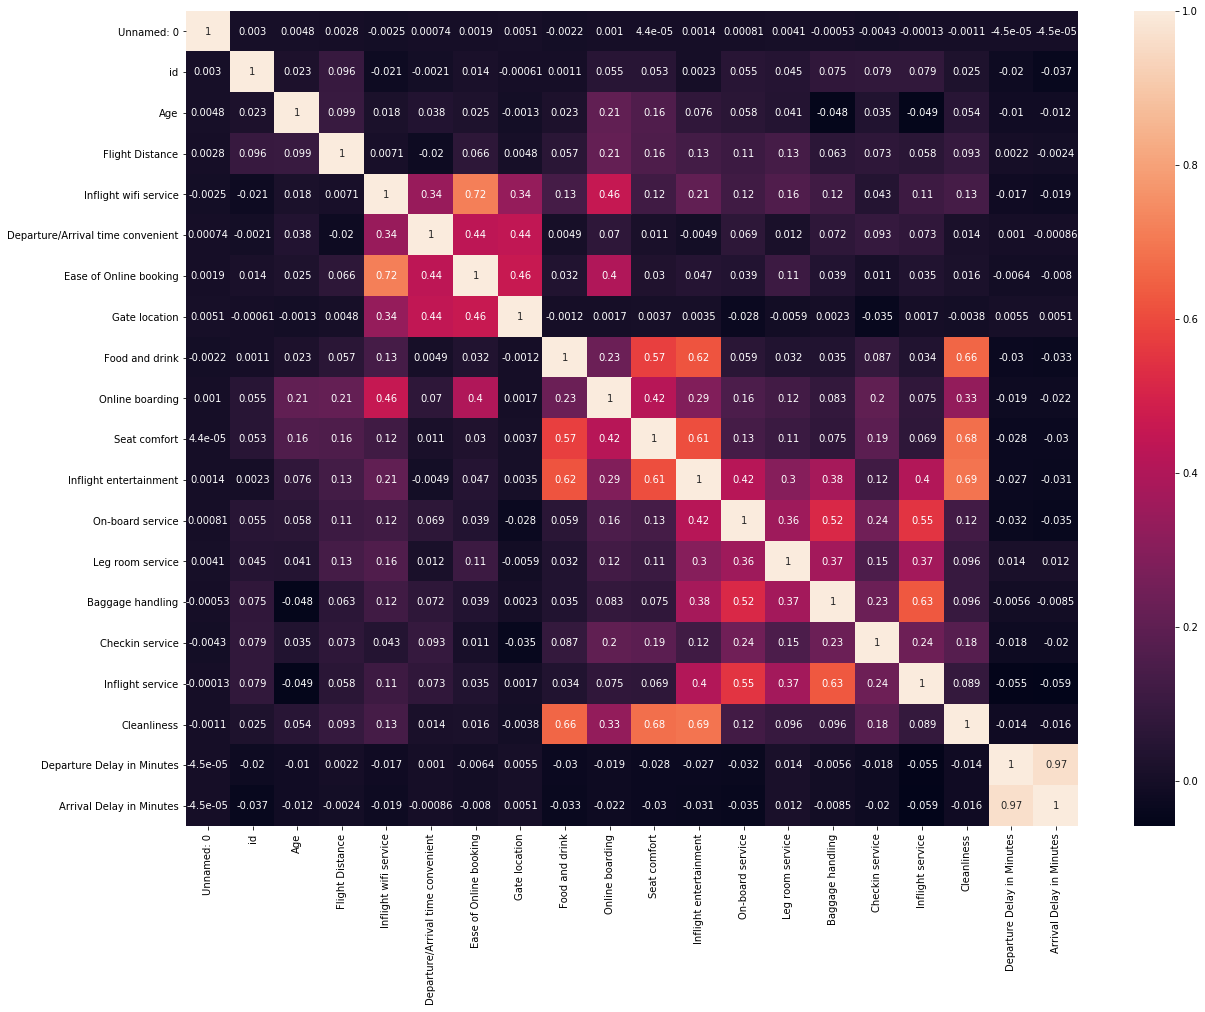

In [889]:
plt.figure(figsize=(20,15))
corrMatrix = df_train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

we will consider any two featrues with more than 0.55 as highly correlated

- We can see that Departure Delay in minutes and arrival delay in minutes are highly correlated.
- Inflight service and seat comfort are highly correlated too.
- food and drinks & seat comfort
- Cleanliness is highly correlated with food and drinks, seat comfort and inflight entertaiment

let's now compare the amount of satisfied passengers compared to the disatisfied ones.

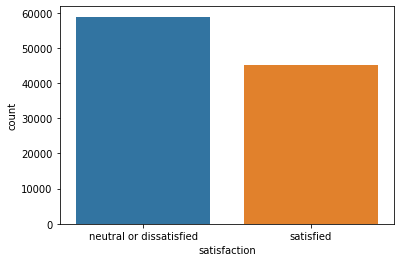

In [1087]:
sns.countplot(x='satisfaction',data=df_train)

As we can see, the number of satisfied passengers is less than the dissatisfied ones but not but that much.

Let's display the features that represent rating values

In [1088]:
def create_barChart(col,index):
    plt.subplot(5,3,index+1)
    sns.countplot(data=df_train, x=col , hue="satisfaction", palette="Paired")
    plt.title(col)
    plt.tight_layout()
    plt.legend()

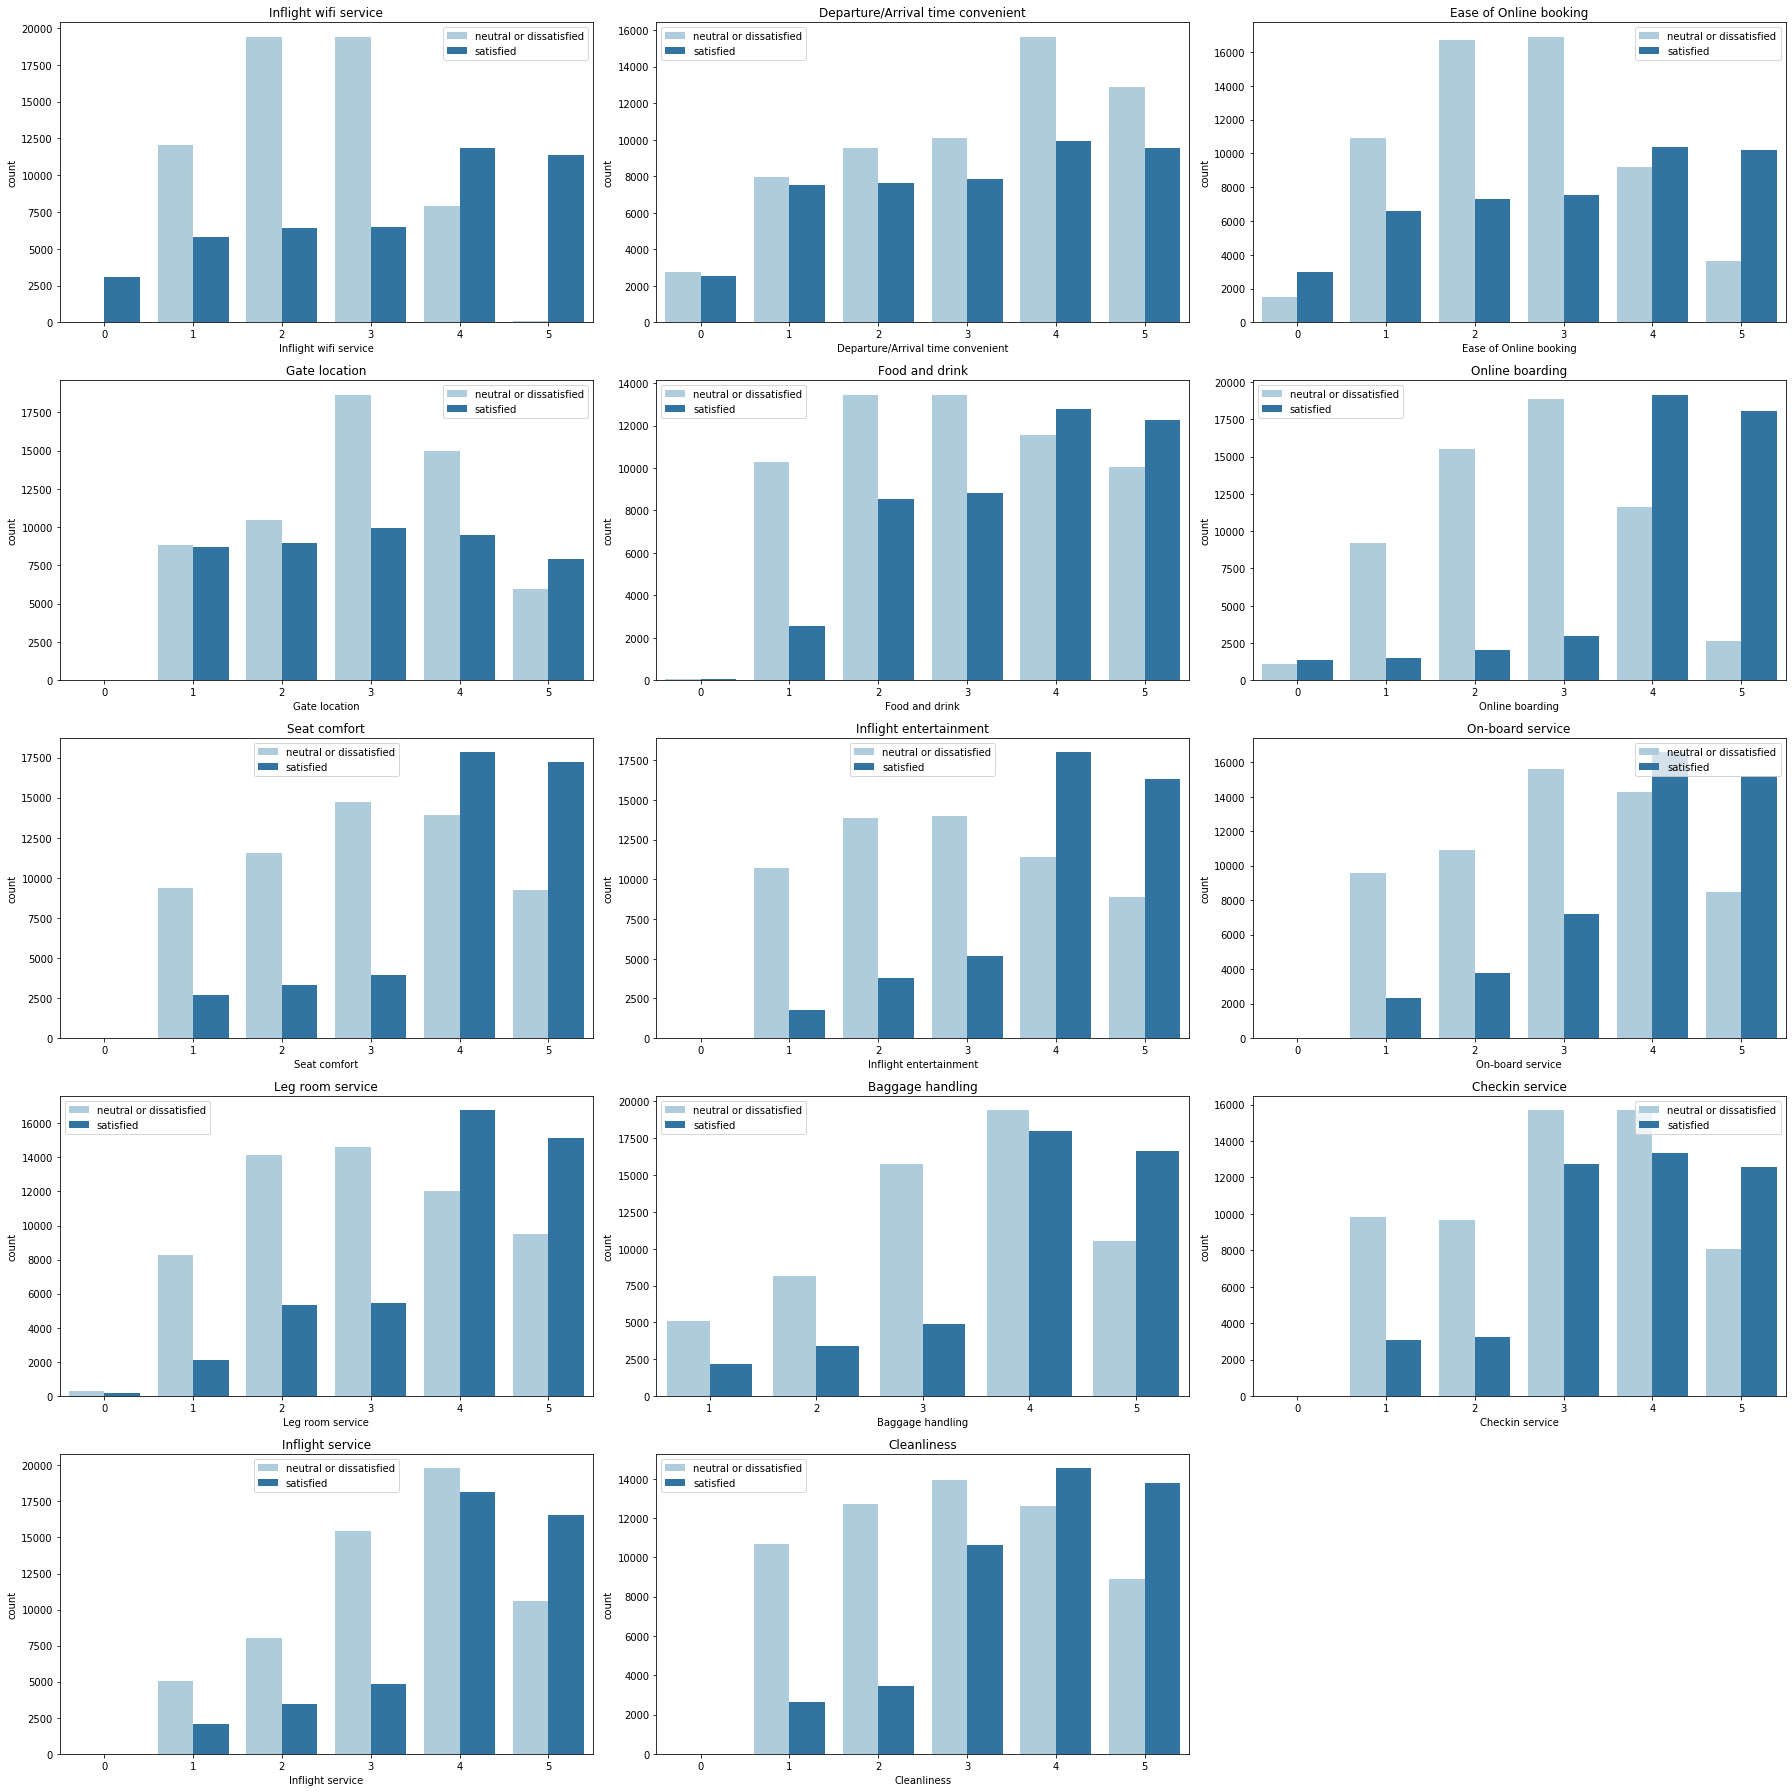

In [1089]:

plt.figure(figsize=(25,25))
for index,col in enumerate(ratings_col):
    create_barChart(col,index)


As we can see, not many passengers gave a 0 ratings the services.

**From the graphs we see above we can see that most satisfied passengers gave high ratings to those features:**
- cleanliness
- leg room service
- inflight entertaiment 
- on-board service
- seat comfort 
- online boarding 
- Baggage handeling

**While most disatisfied passengers gave higher ratings to these features:**
- Departure/Arrival time conveince

**On the other hand, disatisfied passengers gave low ratings to those features:**
 - Food and drinks 
 - leg room service
 - inflight wifi service 
 - Ease of online booking


Now we'll display categorical features

We'll check the gender with each of the categorical features

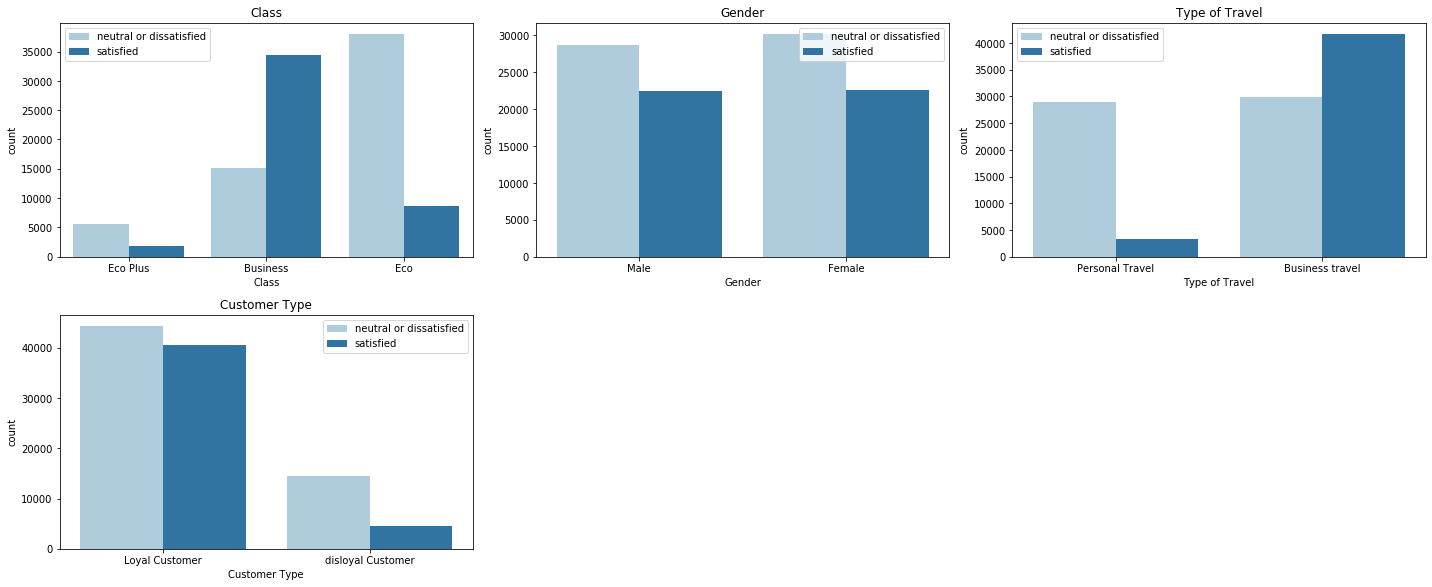

In [1090]:
plt.figure(figsize=(20,20))
for index, value in enumerate(categorical_columns):
    create_barChart(value,index)

**Gender --> Satisfaction**
- we can see very close results between males and females which means we can't really expect this feature to affect the satisfaction.

**Customer Type --> Satisfaction**
- Loyal customers have close results but seem to have a bigger chance of being disatsified with the service
- disloyal customers are mostly disatisfied with the service 

**Type of travel --> Satisfaction**
- The majority of the customers who are traveling for personal reasons are disatisfied, while customers traveling for business reasons are the opposite.

**Class --> Satisfaction**
- Customers who took the business class are mosly satisfied while customers with economy class are mostly disatisfied.


Lets now check how the rest of the features affect the passenger satisfaction

In [1091]:
def plot_hist(value,index):
    plt.subplot(4,4,index+1)
    plt.hist(df_train[value],bins=50)
    plt.xlabel(value)
    plt.ylabel("Fruequency")
    plt.title("{} distribution with histogram".format(value))
    plt.show()

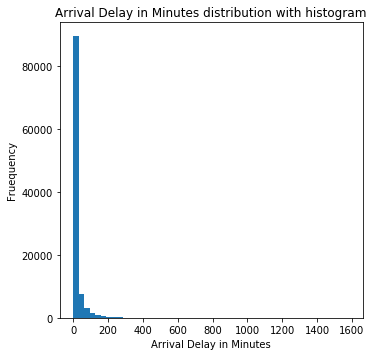

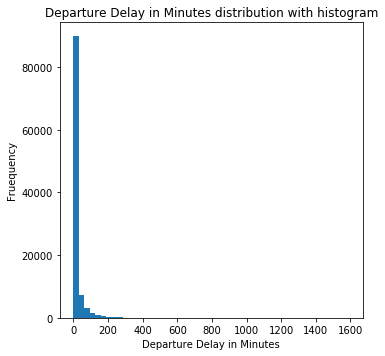

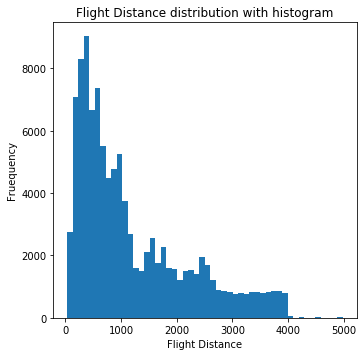

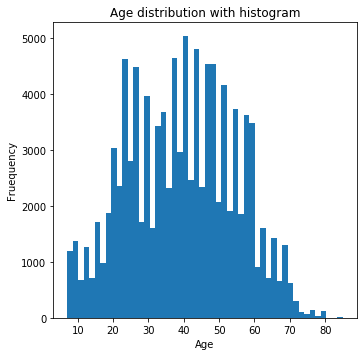

In [1092]:
for index, value in enumerate(columns_to_scale):
    plt.figure(figsize=(25,25))
    plot_hist(value,index)

**Pre-processing / cleaning the data** 

In [1401]:
df_train = pd.read_csv(train_path)
df_test= pd.read_csv(test_path)
# First of all lets remove the non-relevant columns for the analysis.
# non-relevant columns
non_relevant = ['Unnamed: 0','id']
# Drop the non relevant columns and save the changes inplace
# do the same for test and train sets. 
df_train.drop(non_relevant,inplace=True,axis=1)
df_test.drop(non_relevant,inplace=True,axis=1)

The pre processing process will be as follows :
- Since the data contains categorical and numeric values we will separate it into categorical and numeric sets.
- Convert the categories into numeric values and scale the numeric sets.
- Rating columns will also be scaled for getting a similar scale across all data.

This is needed because later on we will perform clustering algorithm which requires all values to be numeric, in addition that normalizing the data would optimize the models we are gonna use during our analysis.

In [1402]:
# Find missing values if there are any
print("Null values in *Train* Data:")
for ind,v in enumerate(df_train.isnull().sum()):
    if v != 0:
        print("Feature: "+df_train.columns[ind],", Number of null values: "+str(v))
print()
print("Null values in *Test* Data:")
for ind,v in enumerate(df_test.isnull().sum()):
    if v != 0:
        print("Feature: "+df_test.columns[ind],", Number of null values: "+str(v))

Null values in *Train* Data:
Feature: Arrival Delay in Minutes , Number of null values: 310

Null values in *Test* Data:
Feature: Arrival Delay in Minutes , Number of null values: 83


According to the previous result , there are missing values in column 'Arrival Delay in Minutes'. to overcome this:
- we will fill the missing values with the mean of the rest in the same column
- we define a function that for a given column and dataframe , it will calculate the mean for a column and fill the missing values

In [1403]:
def fill_mean(df,col):
    mean = np.mean(df[col])
    df[col].fillna(mean,inplace=True)

In [1404]:
# lets call the fill_mean function to fill the missing values
fill_mean(df_train,'Arrival Delay in Minutes')
fill_mean(df_test,'Arrival Delay in Minutes')

In [1405]:
print('Number of null values in train: ',df_train['Arrival Delay in Minutes'].isnull().sum())
print('Number of null values in test: ',df_test['Arrival Delay in Minutes'].isnull().sum())

Number of null values in train:  0
Number of null values in test:  0


This is a helper function that will be used to normalize the data (scaling ,converting categorical into numeric ..)

In [1415]:
def normalize(df,ignore_rating_columns = True):
    res = df.copy()
    # split categorical,columns to scale and ratings columns into subdataframes
    categorical = res[categorical_columns]
    toscale = res[columns_to_scale]
    ratings =res[rating_columns]
    
    # to normalize the categorical values , we will use the oneHotEncoder
    encoder = OneHotEncoder(drop='first')
    encoder_res = encoder.fit_transform(categorical).todense()
    res_features = encoder.get_feature_names(categorical_columns)
    categorical_df = pd.DataFrame(encoder_res,columns=res_features)
    
    # to normalize the toscale columns values, we will use Sklearn MinMaxScaler
    scaler = MinMaxScaler()
    scaler_res = scaler.fit_transform(toscale)
    toscale_df = pd.DataFrame(scaler_res, columns = columns_to_scale)
    
    joined_df = categorical_df.join(toscale_df)
    
    # now return a joined normalized dataframe (combined of all columns types)
    if ignore_rating_columns == False :
        # to normalize the ratings columns values, we will use the oneHotEncoder
        encoder_res = encoder.fit_transform(ratings).todense()
        res_features = encoder.get_feature_names(rating_columns)
        ratings_df = pd.DataFrame(encoder_res, columns = res_features)
        joined_df = joined_df.join(ratings_df)
    else :
        joined_df = joined_df.join(ratings)
    
    return joined_df

In [1422]:
# prepare train and test data
# target_column = satisfaciton , it indicates the ground truth values for each row in the dataset
Y_test = df_test[target_column]
Y_train = df_train[target_column]

X_train = df_train.copy()
#remove the satisfaction column (not relevant since we will cluster/predict upon it)
X_train.drop('satisfaction',inplace=True,axis=1)
normalized_X_train = normalize(X_train,False)

X_test = df_test.copy()
X_test.drop('satisfaction',inplace=True,axis=1)
normalized_X_test = normalize(X_test,False)


Now if we want our data normalized we just use normalized_X_train or normalized_X_test dataframes

In [1426]:
# convert Y_train and Y_test to a dataframe
Y_train = Y_train.to_frame()
Y_test = Y_test.to_frame()

# Question 4

We want to detect the most important features for customer satisfaction, in order to do that:
- Will use Kmeans clustering algorithm and analyse the outcome labels after performing the training
- the data should be numeric and in similar scale (will send a normalized train data)

Since KMeans algorithm requires number of clusters as an input (k),we will do the following:
- will run it with k=2 as there are two labels for satisfaction variable (satisfied / unstatisfied or natural) 
- Interpret and analyse the results.
- if the results are not clear enough , we will find an optimum K and re-run the KMeans algorithm
- since we will run KMeans algorithm multiple times , we define a function that given a K and train data it will run and return the results of kmeans

In [1512]:
def run_kmeans(train_data,k=2):
    kmeans = KMeans(k)
    kmeans.fit(train_data)
    return kmeans

In [1513]:
# Run it with K = 2 and a normalized train data
kmeans = run_kmeans(normalized_X_train , 2)

we will visually analyse the results using the following algorithms:
- TSNE
- PCA
- SOM

Using TSNE,PCA,SOM algorithms
- helps reduce the dimensionality of the data
- we reduce the dimensionality to 2 and plot data points 

In [1309]:
from sklearn.manifold import TSNE

In [1499]:
normalized_X_train = normalize(X_train,False)

In [1500]:
tsne = TSNE(2 , n_iter=250)
transformed_df = tsne.fit_transform(normalized_X_train)

Now the data is reduced , we will perform plotting to see our cluster labels compared to the true labels (satisfaction column)
- we will use plotnine library for displaying the results.

In [719]:
# !pip install plotnine

In [720]:
from plotnine import *

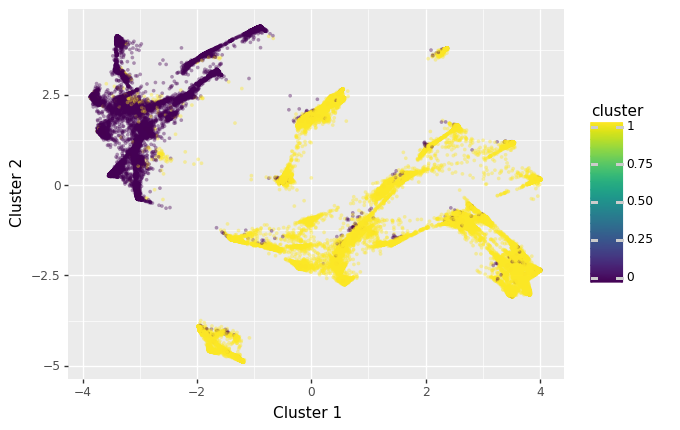

<ggplot: (8783769203193)>

In [1514]:
(
    ggplot(pd.DataFrame({"Cluster 1" : transformed_df[: , 0]
                        ,"Cluster 2" : transformed_df[: , 1]
                        ,"cluster" : kmeans.labels_}) , aes(x="Cluster 1" , y="Cluster 2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0)
)

The labels mostly dont overlap , lets compare this to the ground truth labels (the ones we have in satisfaction column)
- we will plot another column but with different y labels value.


In [1503]:
actual_y = Y_train['satisfaction'].to_numpy()

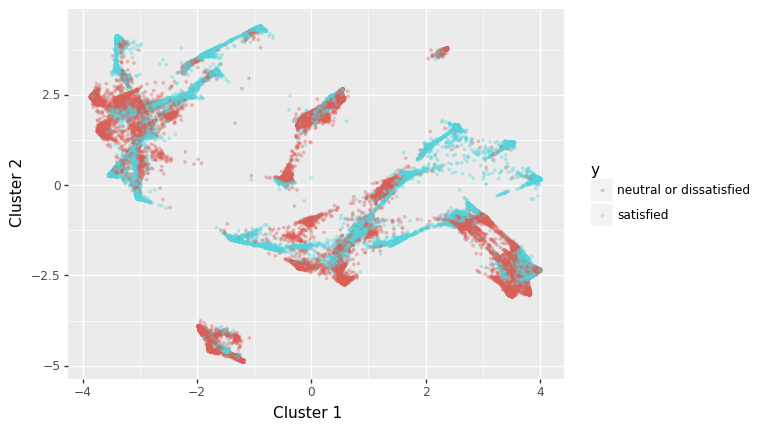

<ggplot: (8783767716965)>

In [1515]:
(
    ggplot(pd.DataFrame({"Cluster 1" : transformed_df[: , 0]
                        ,"Cluster 2" : transformed_df[: , 1]
                        ,"y" : actual_y}) , aes(x="Cluster 1" , y="Cluster 2" , fill="y"))
    + geom_point(alpha=0.4 , stroke=0)
)

Both graphs are mostly similar -> we come up with labels similar to the GT

Now lets do the same but for another visualisation algorithm : PCA

In [1505]:
#n_components=2 as we want to visualize the data in 2 dimention
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_X_train)
pca_df = pd.DataFrame(columns = ['Cluster 1','Cluster 2'])

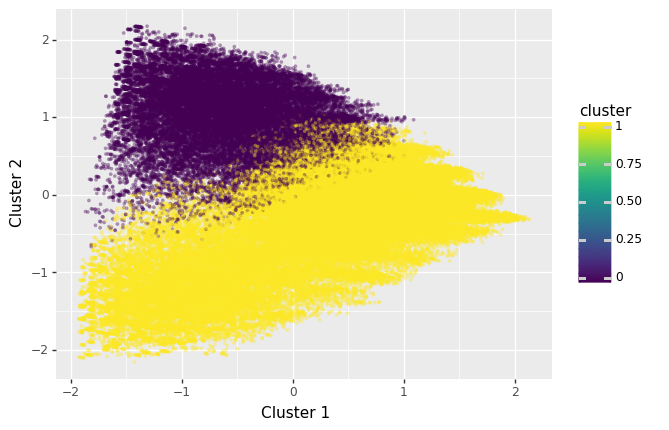

<ggplot: (8783774878649)>

In [1516]:
(
    ggplot(pd.DataFrame({"Cluster 1" : pca_result[: , 0]
                        ,"Cluster 2" : pca_result[: , 1]
                        ,"cluster" : kmeans.labels_}) , aes(x="Cluster 1" , y="Cluster 2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0)
)

The labels mostly dont overlap , lets compare this to the ground truth labels 

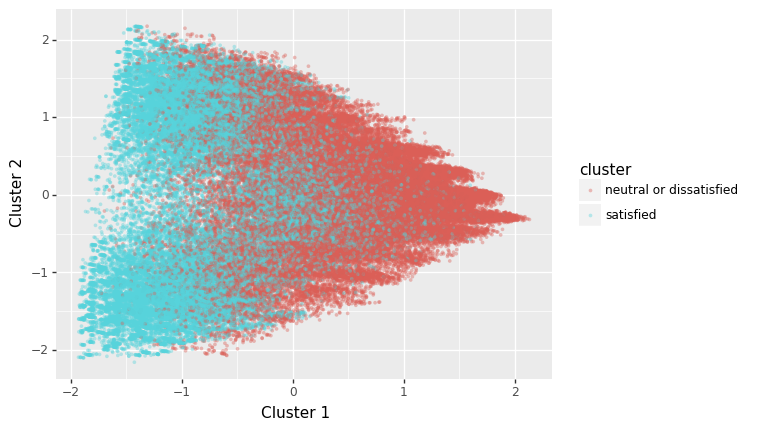

<ggplot: (8783808162961)>

In [1517]:
(
    ggplot(pd.DataFrame({"Cluster 1" : pca_result[: , 0]
                        ,"Cluster 2" : pca_result[: , 1]
                        ,"cluster" : actual_y}) , aes(x="Cluster 1" , y="Cluster 2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0)
)

The results looks slitely different than the ones before but TSNE results were better.

Lastly , we will run SOM
- useful technique for clustering analysis, and exploring data
- SimpSOM library will be used to produce the SOM map

In [728]:
#!pip install SimpSOM

In [1508]:
import SimpSOM as sps

In [1509]:
# Build a network 20x20 with a weights format
#activate Periodic Boundary Conditions. (PPC flag) 
net = sps.somNet(20, 20, normalized_X_train.values, PBC=True)

Periodic Boundary Conditions active.
The weights will be initialised randomly.


In [1510]:
#Train the network for 1000 epochs and with initial learning rate of 0.1. 
net.train(0.01, 1000)

Training SOM... done!


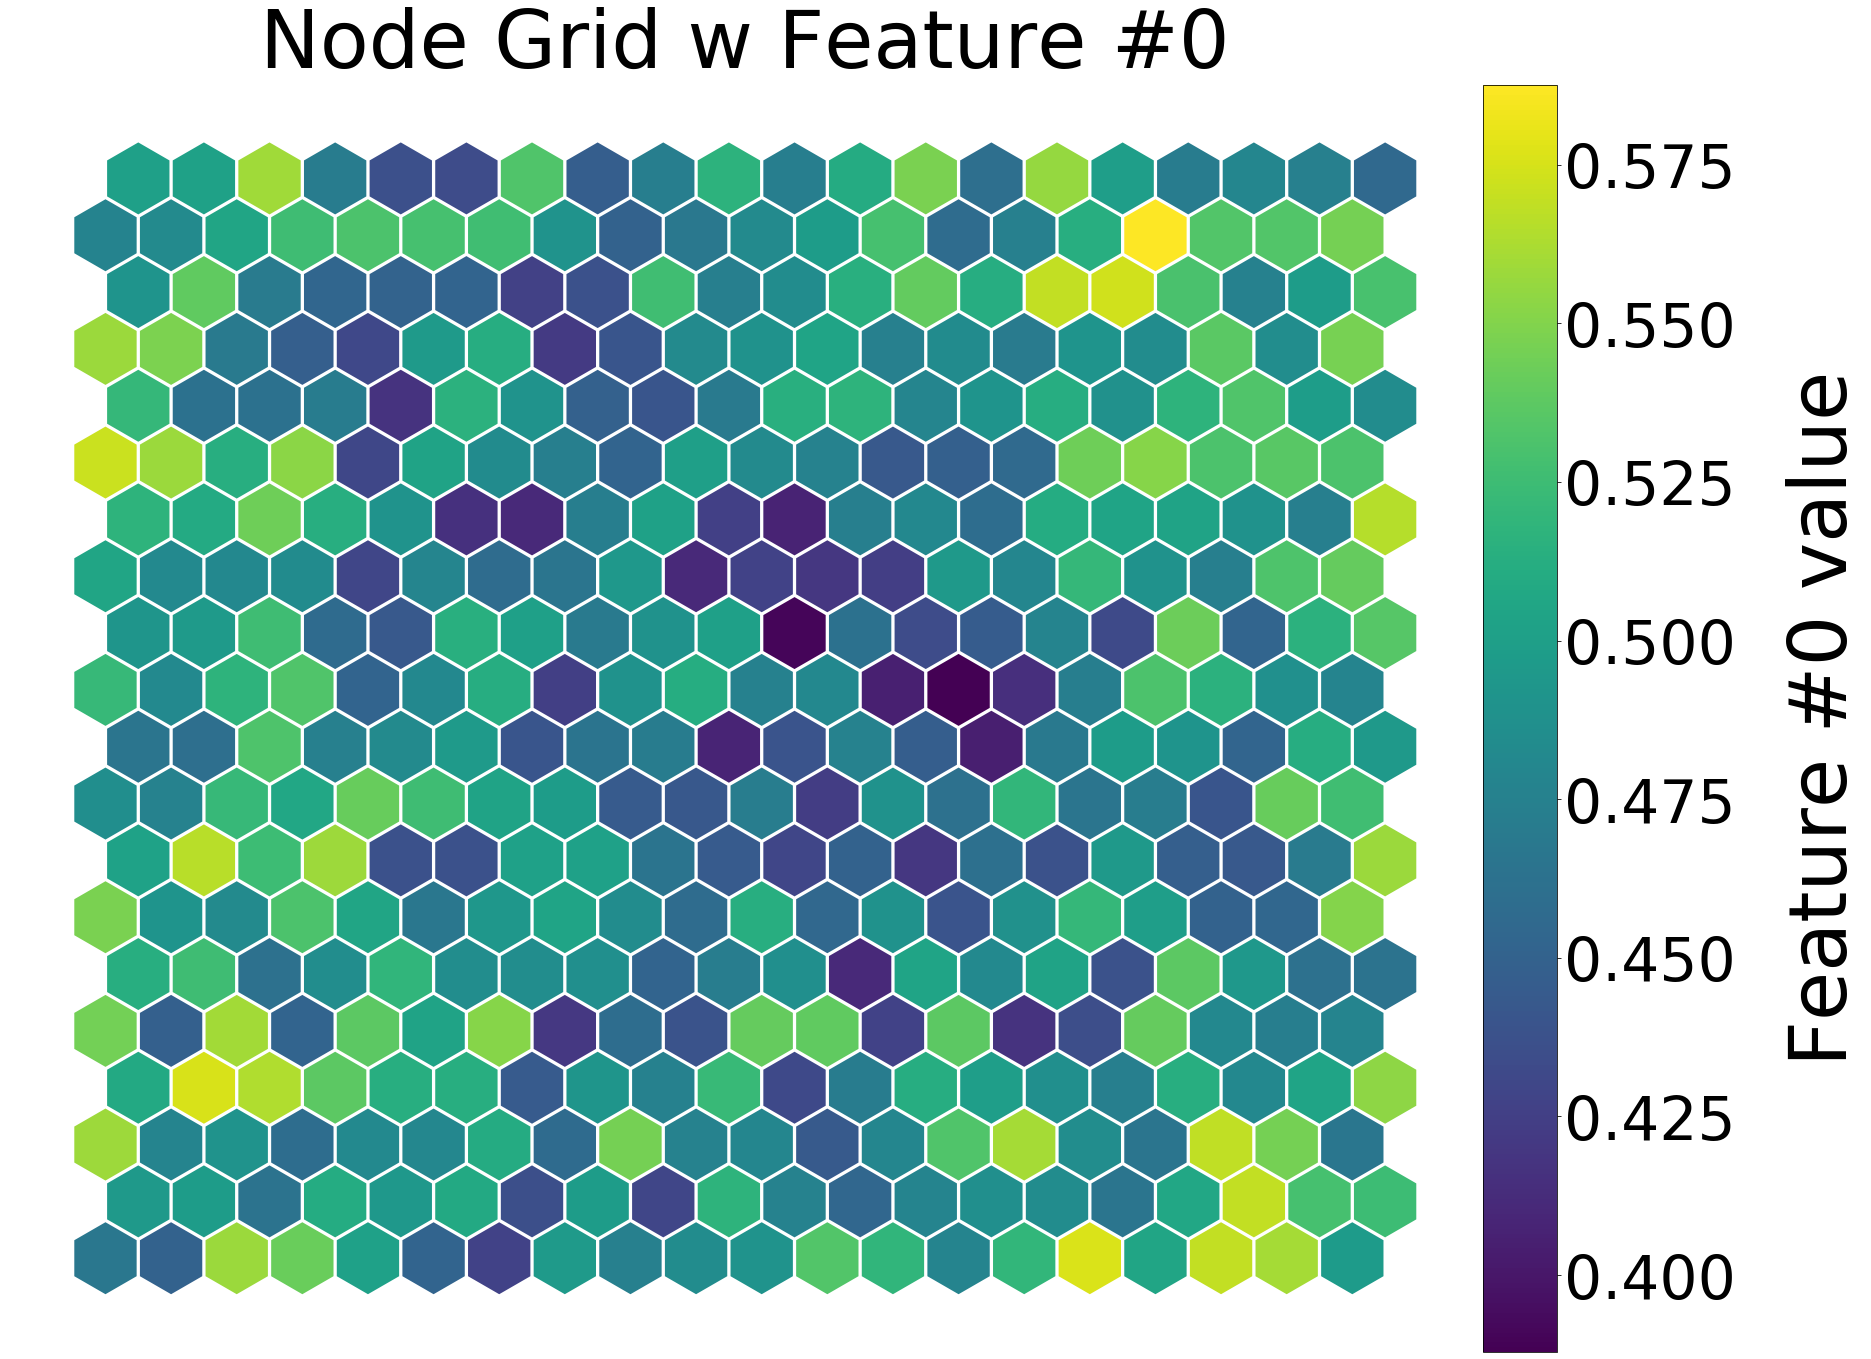

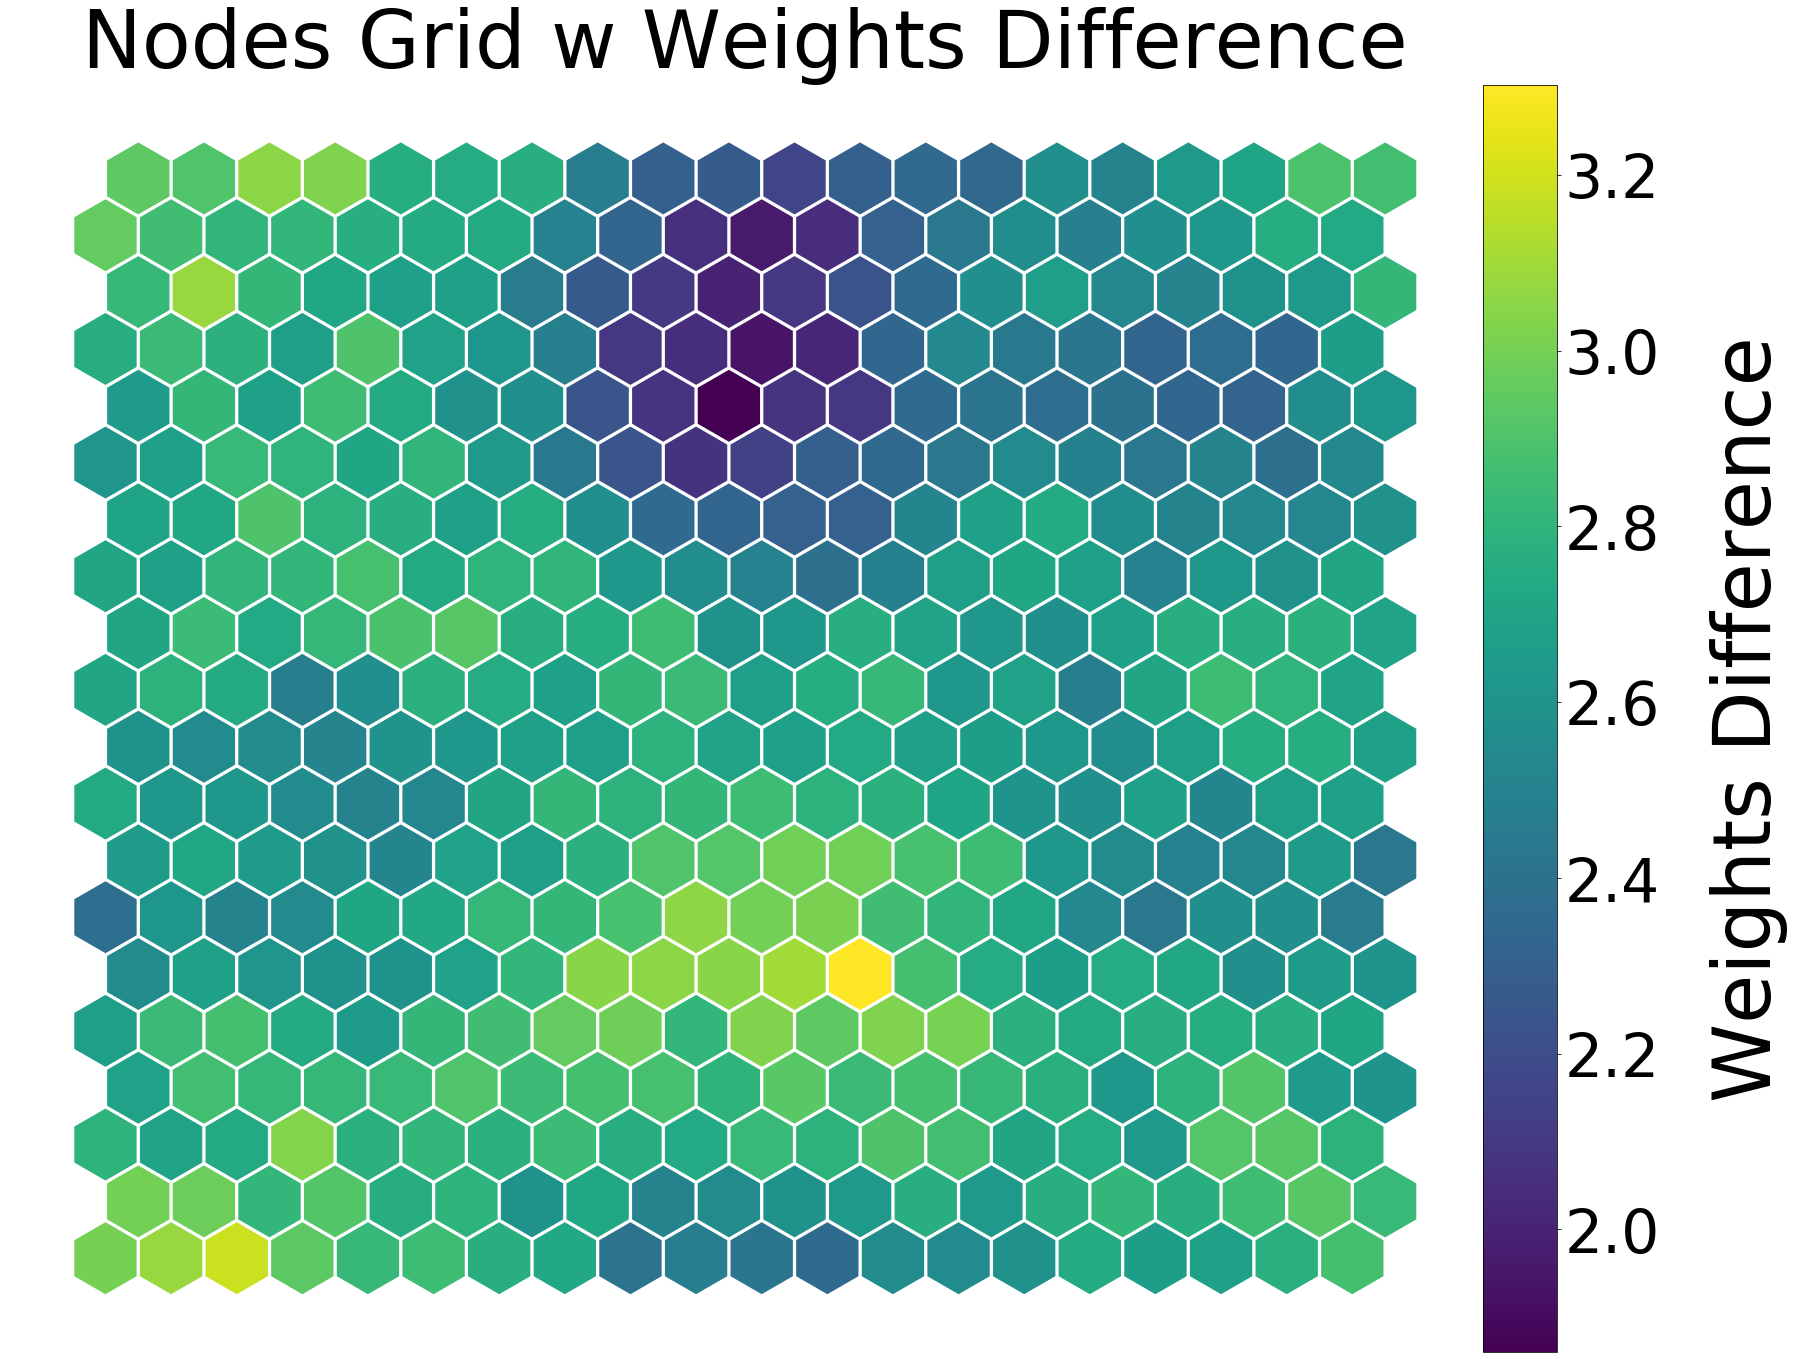

In [1511]:
#Print a map of the network nodes and colour them according
# to the first feature (column number 0) of the dataset
#and then according to the distance between each node and its neighbours.
net.nodes_graph(colnum=0)
net.diff_graph()

From above graphs, a clear clustering of data can be seen such that same colors in the neighbourhood in a cluster and different clusters with different colors

# Analysis over the cluster labels

In [1310]:
# for plotting easily we need to melt the dataframe 
# (so we get a df with two columns one for feature name and another for its mean value in regard to the cluster)
# will define a function that given a dataframe and kmeans.labels will return the melter cluster
def get_melt_cluster(df,labels,inverse = False):
    result_df = df.copy()
    if inverse == True :
        scaler = MinMaxScaler()
        scaler_res = scaler.fit_transform(result_df[columns_to_scale])
        result_df[columns_to_scale] = scaler.inverse_transform(X_train[columns_to_scale])
    result_df["cluster"] = labels
    melt_cluster = result_df.groupby("cluster").mean().reset_index().melt(id_vars="cluster")
    melt_cluster = melt_cluster["variable"].str.split("_" , expand=True).join(melt_cluster)
    melt_cluster = melt_cluster.rename({0 : "variable_base" , 1:"response"} , axis=1)
    melt_cluster["cluster"] = melt_cluster["cluster"].astype("category")
    return melt_cluster

In [1311]:
melt_cluster = get_melt_cluster(normalized_X_train,kmeans.labels_)

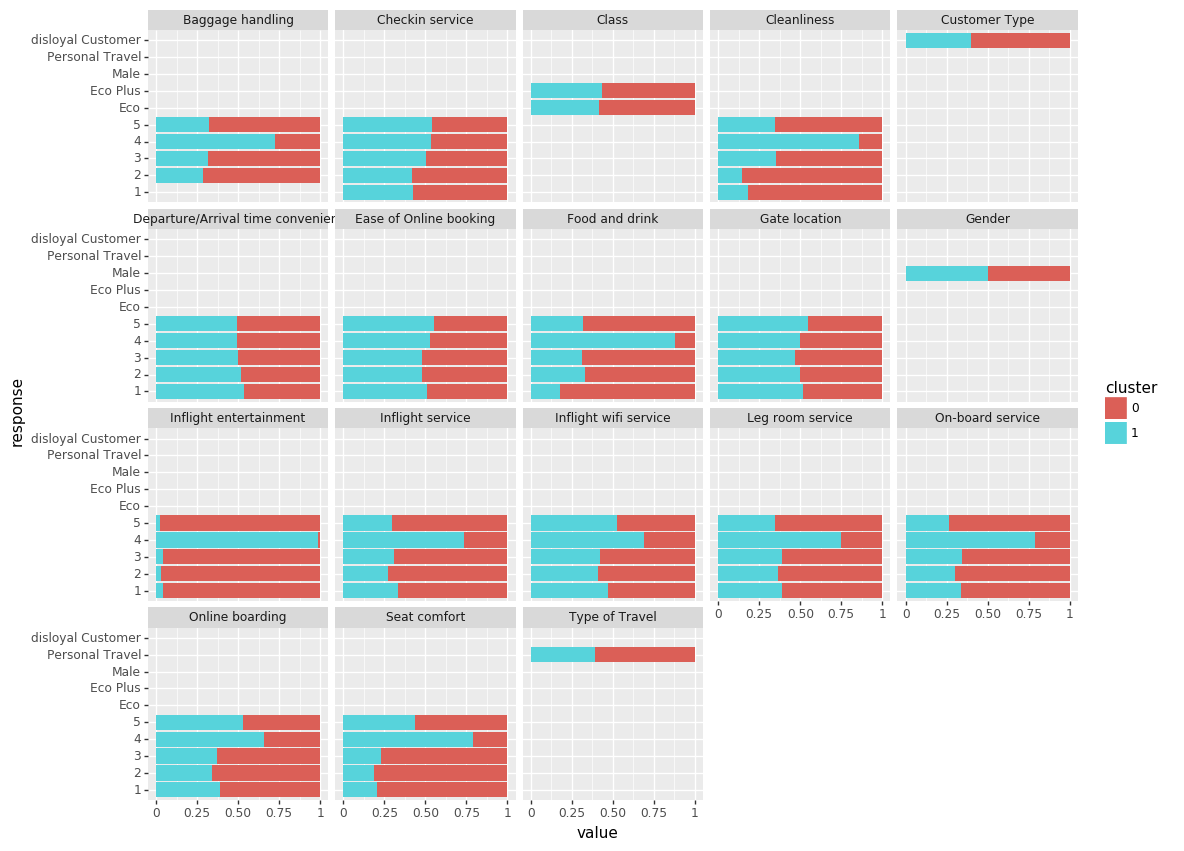

<ggplot: (8783833453509)>

In [1312]:
(
    ggplot(melt_cluster[~melt_cluster["response"].isna()],aes(x="response" , y="value" ,fill="cluster"))
    + geom_col(position="fill")
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(12,10))
)

Results analysis
looking at the previous results represented in individual graphs , we conclude the following for the cluster 0,1 :
- Cluster 0 :
-- mostly people who rated 1-3 the survey questions (sea ocmfort , online boarding ...)\ 
-- Mostly Disloyal customers
-- we can infer from the results that cluster 0 represents people who are mostly disatisfied, because they gave low rating in most of the questions, and since they are mostly disloyal customers, we can conclude that they are once again, mostly distasfied as seen before in the bar charts.
- Cluster 1 :
-- people who travel for business travels (type of travel = business).
-- people who choose buiness class as type of seat
-- people who rated 3-5 survey questions like 'inflight entertainment' , 'food and drink', etc ..
-- By the results above, it seems that cluster1 might represent satisfied passengers, because we know from the displayed data that people who travel for business reason and travel in the business class are mostly satisfied.  


Notes concluded : 
The following features/questions have a very similar results:
- Gender
- Departure/Arrival time 
- Gate Location
- 
(which helps us eliminate them for further analysis)

Since clustering with only two clusters didn't subbly us with enough information about each feature contrbution, we will perform further clustring with disfferent k value(number of clusters) to get a clearler for each feature importance.

to do an even better at the analysis , lets find an optimum k for KMeans clustering and then look again at the results.

In [1247]:
# lets find the optimal K using Elbow method

In [1248]:
from scipy.spatial.distance import cdist

In [1313]:
K = range(2, 15)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
for k in K:
    # Building and fitting the model
    kmeanModel = run_kmeans(normalized_X_train , k)
    distortions.append(sum(np.min(cdist(normalized_X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / normalized_X_train.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(normalized_X_train, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / normalized_X_train.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [1250]:
#Tabulating and Visualizing the results

In [1314]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

2 : 3.324551149752197
3 : 3.226396233949553
4 : 3.1603963894136404
5 : 3.1032532308679706
6 : 3.0507205335706487
7 : 3.0005422032164595
8 : 2.962559818874176
9 : 2.946386409551356
10 : 2.914341154924017
11 : 2.893606435161934
12 : 2.878265605402543
13 : 2.8579932083562887
14 : 2.847037805657672


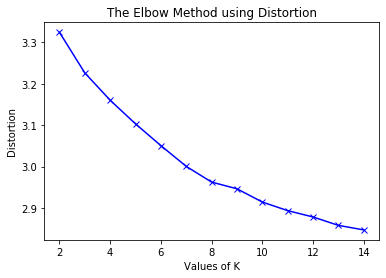

In [1315]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [1316]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

2 : 1153709.2278543774
3 : 1087882.899778127
4 : 1043519.1688078615
5 : 1005694.4248570958
6 : 973353.4070717942
7 : 942462.7508483444
8 : 918449.0481389194
9 : 909388.6944478982
10 : 890055.5059409797
11 : 876561.8559558238
12 : 868748.7965987585
13 : 858294.5607846837
14 : 851393.734607718


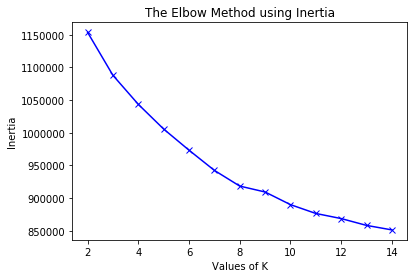

In [1317]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 8

In [1318]:
# now lets re-run the kmeans algorithm with K=8 and see the results

In [1319]:
k = 8
kmeans = run_kmeans(normalized_X_train , k)
melt_cluster = get_melt_cluster(normalized_X_train,kmeans.labels_)

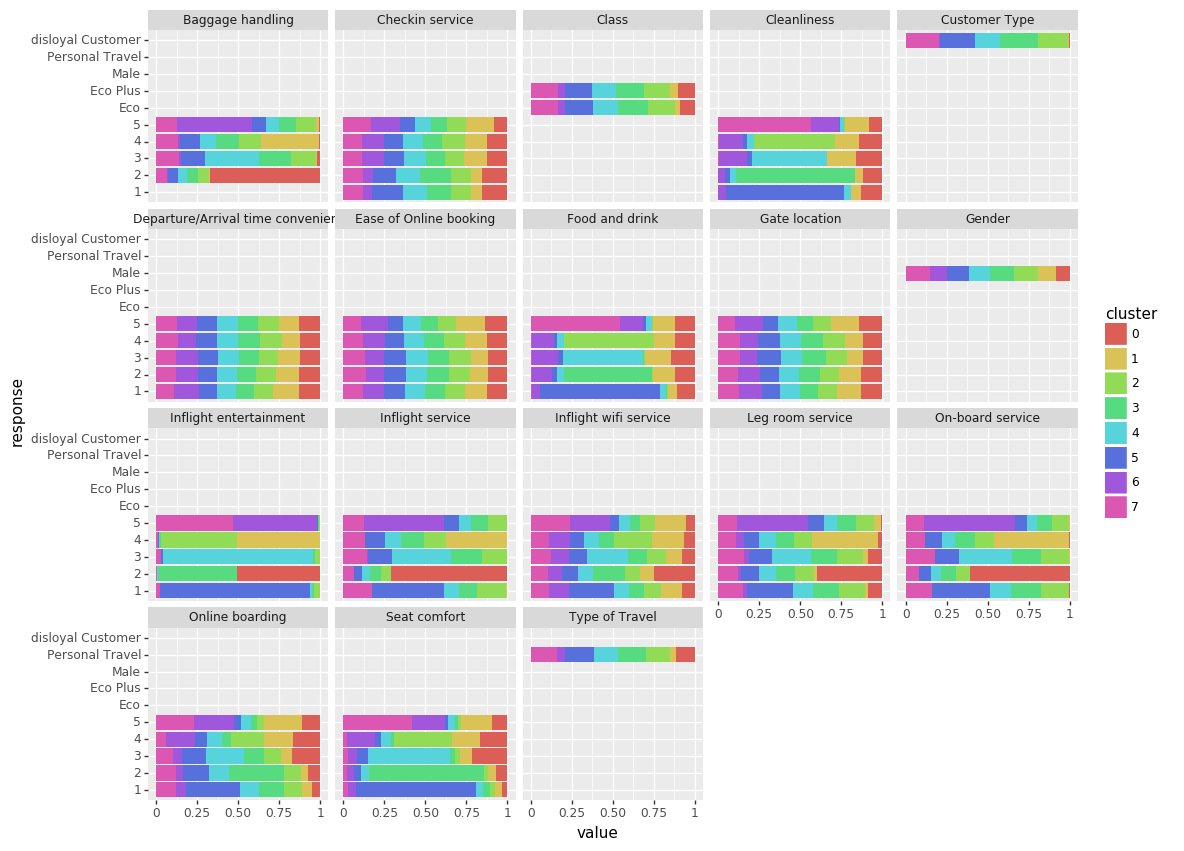

<ggplot: (8783809103217)>

In [1320]:
(
    ggplot(melt_cluster[~melt_cluster["response"].isna()],aes(x="response" , y="value" ,fill="cluster"))
    + geom_col(position="fill")
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(12,10))
)

Now we are going to display the plots for numerical features (pre-scaled)

In [1321]:
mcsv = get_melt_cluster(normalized_X_train,kmeans.labels_,True)
# mcsv = melted cluster scaled values

Since the response values from the melted df is supposed to be None , we will filter them from the melted cluster and display them according to their original values.

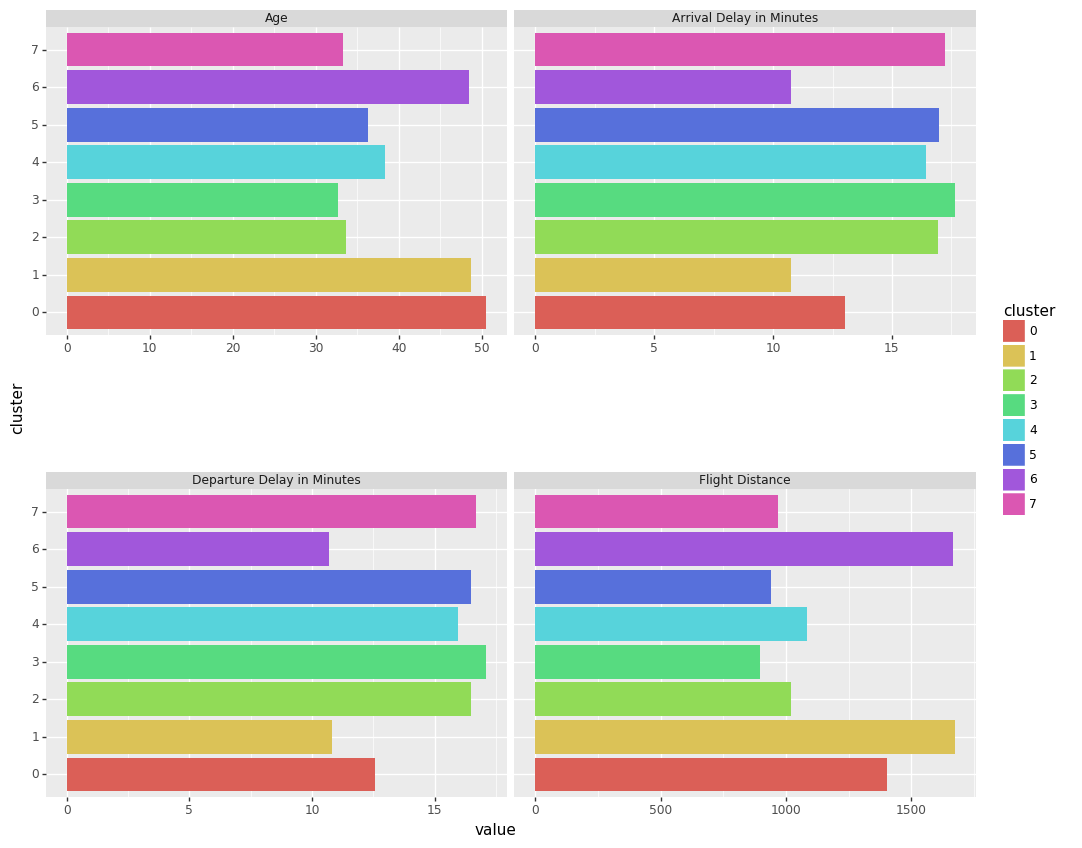

<ggplot: (8783809171425)>

In [1322]:
(
    ggplot(mcsv[mcsv["response"].isna()],aes(x="cluster" , y="value" ,fill="cluster"))
    + geom_col()
    + coord_flip()
    + facet_wrap("~ variable_base", scales="free_x")
    + theme(figure_size=(12,10),subplots_adjust={'hspace': 0.5})
)

Results analysis
looking at the previous results graphs after updating the K clusters , we came into new conclusions:
The following features contribute the most into the passenger satisfaction:
1- Inflight entertainment
2- Inflight service 
3- Food and drinks
4- seat comfort
5 - cleanliness 
Because the ratio for each one of the 8 clusters for each feature value varies. for example for the Inflight entertainment which shows the most variation, we can see that clusters 4 and 5 dominate the ratings for values 3 and 1. For the feature cleanliness the cluster 7, 3 and 5 dominate the ratings for values 1, 2 and 5. The same pattern of clusters dominating 1 value in the ratings applies for the rest of the features we mentioned above. 

As concluded before with a different value of K the following features/questions have a very similar results (can be excluded for an extra run):
- Gender
- Departure/Arrival time 
- Ease of online booking
- Class
- Gate Location

we will perform an experiment , 
lets group the following features into a new feature and re-run the clustering:
- 'Departure/Arrival time convenient'
- 'Ease of Online booking'
- 'Gate location'

In [1354]:
X_train_grouped = X_train.copy()
to_group = ['Departure/Arrival time convenient','Ease of Online booking','Gate location']

In [1355]:
X_train_grouped['New Feature']= X_train_grouped[to_group].mean(axis=1).astype(int) 

In [1356]:
X_train_grouped.drop(to_group,inplace=True,axis=1)

In [1357]:
# save a copy of the global rating_columns array
rating_columns_bck = rating_columns
# remove the grouped columns from the global rating_columns array
rating_columns = list(set(rating_columns)-set(to_group))
rating_columns.append('New Feature')

# normalize the X_train_grouped 
X_train_grouped_normalized = normalize(X_train_grouped)

# Restore rating columns to their original state
rating_columns = rating_columns_bck

In [1359]:
k = 8
kmeans = run_kmeans(X_train_grouped_normalized , k)
melt_cluster = get_melt_cluster(X_train_grouped_normalized,kmeans.labels_)

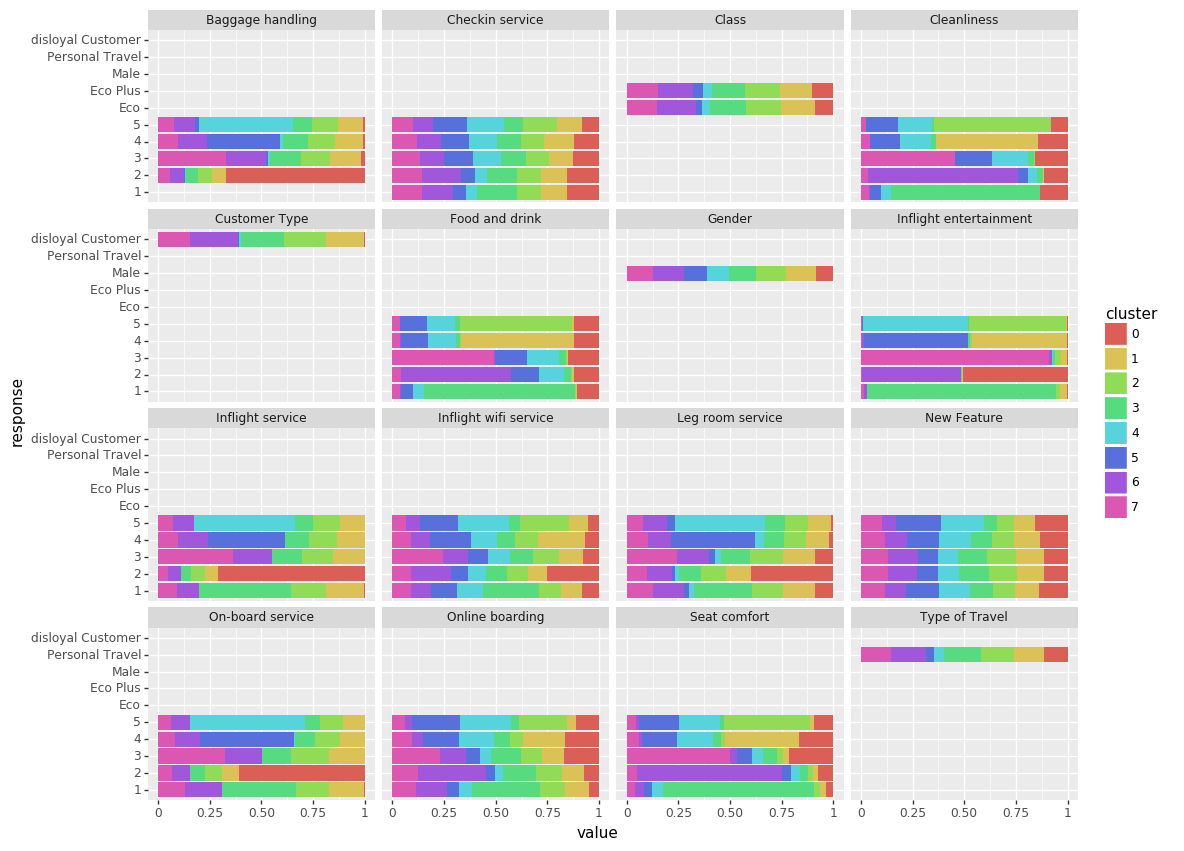

<ggplot: (8783808161965)>

In [1360]:
(
    ggplot(melt_cluster[~melt_cluster["response"].isna()],aes(x="response" , y="value" ,fill="cluster"))
    + geom_col(position="fill")
    + coord_flip()
    + facet_wrap("~ variable_base")
    + theme(figure_size=(12,10))
)

After grouping the three features that we thought were the least important, we got the results above.
From those results we can confirm that the grouped features had very little impact on the satisfaction, we can also see that the best 5 features remain as before.

# Question 5

To Maximize the classification for customers satisfcation , we will run several classification algorithms and eventually discuss the results.

- For this purpose we will use the following algorithms:
    - ADABOOST
    - Random Forset
    - Neural nets
    - SGD
    - CatBoost

Let's starts with ADABOOST

In [1521]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [1522]:
# Helper function to display the correlation matrix
def corr_matrix(model_pred, X_test, Y_test ):
    plot_confusion_matrix(model_pred, X_test, Y_test,cmap=plt.cm.Blues, normalize = 'all')

In [1523]:
actual_y = Y_train['satisfaction'].to_numpy()
actual_y_test = Y_test['satisfaction'].to_numpy()

In [1524]:
normalized_X_train = normalize(X_train,True)
normalized_X_test = normalize(X_test,True)

                         precision    recall  f1-score   support

neutral or dissatisfied    0.92857   0.94112   0.93481     14573
              satisfied    0.92343   0.90748   0.91539     11403

               accuracy                        0.92636     25976
              macro avg    0.92600   0.92430   0.92510     25976
           weighted avg    0.92632   0.92636   0.92628     25976



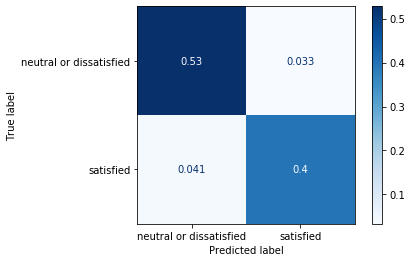

In [1536]:
clf_ada = AdaBoostClassifier(random_state=1)
clf_ada.fit(normalized_X_train, actual_y)
#AdaBoostClassifier(n_estimators=100, random_state=0)
ada_pred = clf_ada.predict(normalized_X_test)
#print('Accuracy: {}'.format(accuracy_score(y_pred, Y_test)))
print(classification_report(actual_y_test,ada_pred,digits=5))
corr_matrix(clf_ada, normalized_X_test, actual_y_test)

In [1537]:
ada_acc = metrics.accuracy_score(actual_y_test, ada_pred)

As we can see the Adaboost got accuracy of 93% which is good, but we can try more algorithms for better accuracy.
The same goes for precision and recall. 

**Lets try Random Forset**

In [1431]:
from sklearn.ensemble import RandomForestClassifier

                         precision    recall  f1-score   support

neutral or dissatisfied    0.85093   0.93927   0.89292     14573
              satisfied    0.91052   0.78970   0.84582     11403

               accuracy                        0.87361     25976
              macro avg    0.88072   0.86449   0.86937     25976
           weighted avg    0.87708   0.87361   0.87224     25976



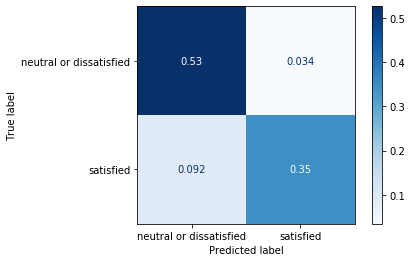

In [1434]:
clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
clf_RF.fit(normalized_X_train, actual_y)
RF_pred = clf_RF.predict(normalized_X_test)
print(classification_report(actual_y_test,RF_pred,digits=5))
corr_matrix(clf_RF, normalized_X_test, actual_y_test)


Random Forest got a 87% accuracy which is worse than Adaboost, as for precision and recall the results aren't that good either.

In [1532]:
rnd_acc = metrics.accuracy_score(actual_y_test, RF_pred)
print(rnd_acc)

0.8736141053279951


**Neural nets**

In [1446]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
train_X = normalized_X_train.copy()
test_X = normalized_X_test.copy()
scaler.fit(train_X) 
train_X = scaler.transform(train_X)  
# apply same transformation to test data
test_X = scaler.transform(test_X)

                         precision    recall  f1-score   support

neutral or dissatisfied    0.94217   0.97036   0.95605     14573
              satisfied    0.96061   0.92388   0.94189     11403

               accuracy                        0.94995     25976
              macro avg    0.95139   0.94712   0.94897     25976
           weighted avg    0.95026   0.94995   0.94983     25976



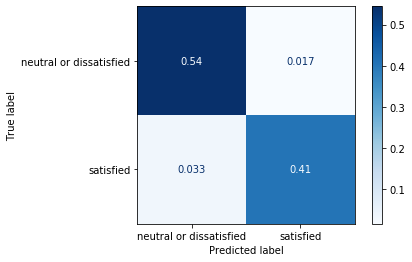

In [1449]:
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1,max_iter = 10000)

clf_nn.fit(train_X, actual_y)
nn_pred = clf_nn.predict(test_X)
print(classification_report(actual_y_test,nn_pred,digits=5))
corr_matrix(clf_nn, test_X, actual_y_test)


The results we got are very close to the results of Adaboost, yet Neural nets got higher accuracy, we will try more models to see if we can improve the accuracy.

In [1533]:
nn_acc = metrics.accuracy_score(actual_y_test, nn_pred)
print(nn_acc)

0.9499538035109332


In [1451]:
from sklearn.linear_model import SGDClassifier

                         precision    recall  f1-score   support

neutral or dissatisfied    0.86977   0.89364   0.88154     14573
              satisfied    0.85913   0.82899   0.84379     11403

               accuracy                        0.86526     25976
              macro avg    0.86445   0.86132   0.86267     25976
           weighted avg    0.86510   0.86526   0.86497     25976



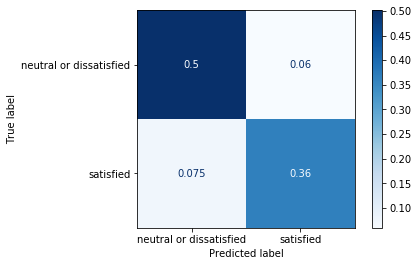

In [1453]:
clf_SGD = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=10000)
clf_SGD.fit(train_X, actual_y)
SGD_pred = clf_SGD.predict(test_X)
print(classification_report(actual_y_test,SGD_pred,digits=5))
corr_matrix(clf_SGD, test_X, actual_y_test)

SGD got the worst results so far between the previous models, yet it is not that bad either for a classfier.

In [1534]:
sgd_acc = metrics.accuracy_score(actual_y_test, SGD_pred)
print(sgd_acc)

0.8652602402217432


CatBoost

In [769]:
#!pip install catboost

In [1441]:
import catboost as cb

                         precision    recall  f1-score   support

neutral or dissatisfied    0.95394   0.96926   0.96154     14573
              satisfied    0.95989   0.94019   0.94994     11403

               accuracy                        0.95650     25976
              macro avg    0.95691   0.95472   0.95574     25976
           weighted avg    0.95655   0.95650   0.95645     25976



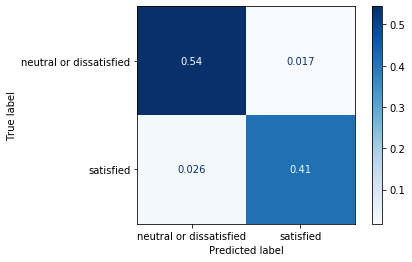

In [1442]:
clf_cb = cb.CatBoostClassifier(iterations=10000,
                          learning_rate=1,
                          depth=2,silent=True)
clf_cb.fit(normalized_X_train, actual_y)
cb_pred = clf_cb.predict(normalized_X_test)
print(classification_report(actual_y_test,cb_pred,digits=5))
corr_matrix(clf_cb, normalized_X_test, actual_y_test)

As for CatBoost we can see that it got the highest score, which is 95% out of all the previous models

In [1535]:
cat_acc = metrics.accuracy_score(actual_y_test, cb_pred)
print(cat_acc)

0.9564983061287342


In [1544]:
#Finally we will demonstrate the accuracy we got by runnung all different models we ran above.
auc_scores = [ada_acc,rnd_acc, nn_acc, sgd_acc, cat_acc]
model_scores = pd.DataFrame(auc_scores, index=['AdaBoost','Random Forest','NeuralNets','SGD','Catboost'], columns=['Accuracy'])
model_scores.sort_values('Accuracy',ascending=False).head()

,Accuracy
Catboost,0.956498
NeuralNets,0.949954
AdaBoost,0.926355
Random Forest,0.873614
SGD,0.865260


we presented the accuracy of all the models sorted, and it once again shows Catboost as the best classifier and SGD as the worst of all five.

# Question 6

To select the three features we will perform feature selection on the adaboost classification results, since it gave is the best results.

In [1455]:
df_feature_importance = pd.DataFrame(clf_cb.feature_importances_, index=normalized_X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.head()


,feature importance
Inflight wifi service,31.410379
Type of Travel_Personal Travel,14.017902
Online boarding,8.713521
Customer Type_disloyal Customer,7.122201
Inflight entertainment,4.240893


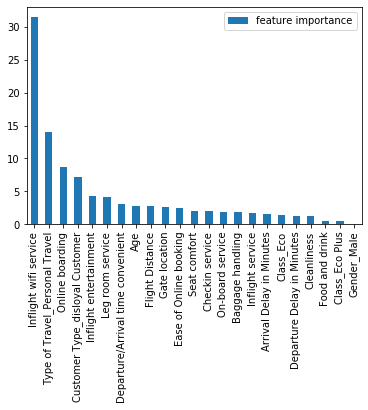

In [1456]:
df_feature_importance.plot(kind='bar')

- As we can see from the bar chart above, the top 5 most important features are:
  - Inflight wifi service
  - Type of travel
  - Online boarding
  - Customer Type
  - Inflight entertainment
  
We will group those 5 features into one new label and call it satisfaction rate  

In [1463]:

group_by_columns = ['Inflight wifi service', 'Online boarding', 'Seat comfort', 'Leg room service', 'Inflight service']
#train
tmp_train_df = normalized_X_train.copy()
tmp_train_df = tmp_train_df[group_by_columns]
tmp_train_df['Satisfaction rate'] = tmp_train_df.mean(axis=1)

#test
tmp_test_df = normalized_X_test.copy()
tmp_test_df = tmp_test_df[group_by_columns]
tmp_test_df['Satisfaction rate'] = tmp_test_df.mean(axis=1)


##preparing the train data
new_train_df = normalized_X_train.copy()
new_train_df.drop(group_by_columns, inplace =True, axis=1)
new_X_train = new_train_df.copy()
new_train_df['Satisfaction rate'] = tmp_train_df['Satisfaction rate']

#preparing the test data 
new_test_df = normalized_X_test.copy()
new_test_df.drop(group_by_columns, inplace =True, axis=1)
new_X_test = new_test_df.copy()
new_test_df['Satisfaction rate'] = tmp_test_df['Satisfaction rate']

 
new_Y_train = new_train_df['Satisfaction rate']
new_Y_test = new_test_df['Satisfaction rate']

new_Y_train.to_frame
print(type(new_Y_train))
new_Y_test.to_frame


<class 'pandas.core.series.Series'>


<bound method Series.to_frame of 0        4.4
1        3.6
2        1.8
3        2.0
4        1.8
        ... 
25971    3.4
25972    4.4
25973    2.4
25974    3.6
25975    1.8
Name: Satisfaction rate, Length: 25976, dtype: float64>

In [1465]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [1470]:
def features_importance(importance, df,model):
    for i,v in enumerate(importance):
        print('%d- Feature: %s, Score: %.9f' % (i,df.columns[i],v))
    # plot feature importance
    #plt.figure(figsize=(15,7))
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
    ax.set_xticks(np.arange(len(importance)))
    plt.bar([x for x in range(len(importance))], importance)
    plt.ylabel('Score')
    plt.xlabel('Feature Number')
    plt.title(model+' Feature Importance')
    plt.show()

In [1471]:
#visualizing test set results
def plot_result(feature,pred,df = new_X_test):
    plt.figure(figsize=(15,7))
    plt.scatter(df[feature][:20].index, new_Y_test[:20], color = 'red')
    plt.plot(df[feature][:20].index, pred, color = 'blue') #this should not change as the regressor fitted to train set should be shown
    plt.title(feature)
    plt.xlabel("index")
    plt.ylabel("rating")
    plt.show()


**Linear Regression**

0- Feature: Gender_Male, Score: -0.023238860
1- Feature: Customer Type_disloyal Customer, Score: -0.132808290
2- Feature: Type of Travel_Personal Travel, Score: -0.097842819
3- Feature: Class_Eco, Score: -0.115860111
4- Feature: Class_Eco Plus, Score: -0.125868977
5- Feature: Arrival Delay in Minutes, Score: -0.577077222
6- Feature: Departure Delay in Minutes, Score: 0.182517196
7- Feature: Flight Distance, Score: 0.029161396
8- Feature: Age, Score: 0.211726976
9- Feature: Departure/Arrival time convenient, Score: -0.003816100
10- Feature: Ease of Online booking, Score: 0.239579132
11- Feature: Gate location, Score: -0.045171012
12- Feature: Food and drink, Score: -0.005606327
13- Feature: Inflight entertainment, Score: 0.189873372
14- Feature: On-board service, Score: 0.068752614
15- Feature: Baggage handling, Score: 0.105010625
16- Feature: Checkin service, Score: 0.074665137
17- Feature: Cleanliness, Score: 0.088074940


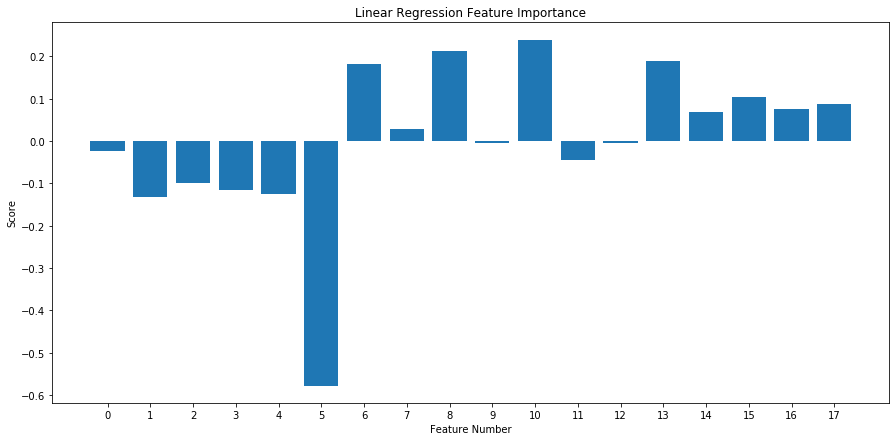

In [1472]:
reg = linear_model.LinearRegression()

reg.fit(new_X_train,new_Y_train)
pred1 = reg.predict(new_X_test[:20])
reg.score(new_X_train, new_Y_train)
importance = reg.coef_
model = "Linear Regression"
features_importance(importance,new_X_train,model)


Ease of Online booking feature got the highest score, while Arrival Delay in Minutes got the lowest score.

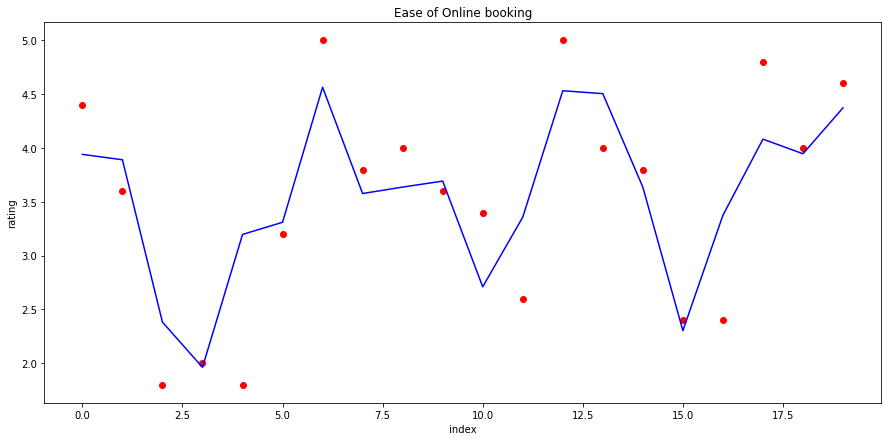

In [1473]:
best_feature = "Ease of Online booking"

plot_result(best_feature,pred1)

The graph above compares between the predicted values and the actual test values, The line being the predicted results and the scatter point being the actual test values.
As we can see the model did a good job predicting some of the values, but not good enough for the rest.

Visualizing the results

In [1474]:
from sklearn import preprocessing
from sklearn import utils
def encode(new_Y_train):
    lab_enc = preprocessing.LabelEncoder()
    encoded = lab_enc.fit_transform(new_Y_train.copy())
    return encoded

In [1475]:
#new_Y_train

**PLS Regression**

In [1476]:
from sklearn.cross_decomposition import PLSRegression

In [1551]:
log_reg = PLSRegression(n_components=2)
log_reg.fit(new_X_train,new_Y_train)
pred2 = log_reg.predict(new_X_test[:20])
log_reg.score(new_X_train,new_Y_train)
importance = log_reg.coef_
model = "PLS Regression"

In [1552]:
tmp_imp = []
for ind,val in enumerate(importance): tmp_imp.append(val[0])

In [1553]:
importance = tmp_imp

0- Feature: Gender_Male, Score: -0.010474680
1- Feature: Customer Type_disloyal Customer, Score: -0.037446676
2- Feature: Type of Travel_Personal Travel, Score: -0.062509040
3- Feature: Class_Eco, Score: -0.060917011
4- Feature: Class_Eco Plus, Score: -0.037499836
5- Feature: Arrival Delay in Minutes, Score: -0.001258187
6- Feature: Departure Delay in Minutes, Score: 0.000550707
7- Feature: Flight Distance, Score: 0.015523459
8- Feature: Age, Score: 0.042993491
9- Feature: Departure/Arrival time convenient, Score: 0.056290269
10- Feature: Ease of Online booking, Score: 0.270459796
11- Feature: Gate location, Score: 0.015721283
12- Feature: Food and drink, Score: 0.041705741
13- Feature: Inflight entertainment, Score: 0.178508355
14- Feature: On-board service, Score: 0.127474327
15- Feature: Baggage handling, Score: 0.140348383
16- Feature: Checkin service, Score: 0.085874908
17- Feature: Cleanliness, Score: 0.105400541


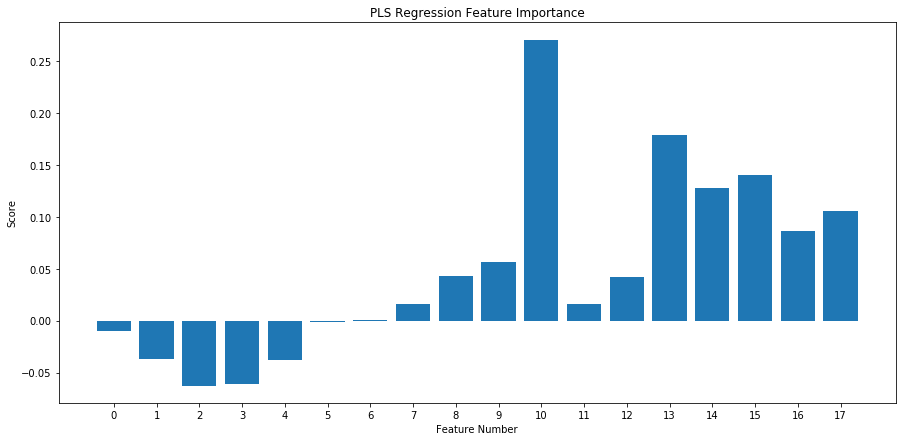

In [1554]:
features_importance(importance,new_X_train,model)

Again we got as a result that ease of online booking is the best important feature according to the PLS regressor, Inflight entertainment coming second.
The worst feature is Customer type which kinda surprising.

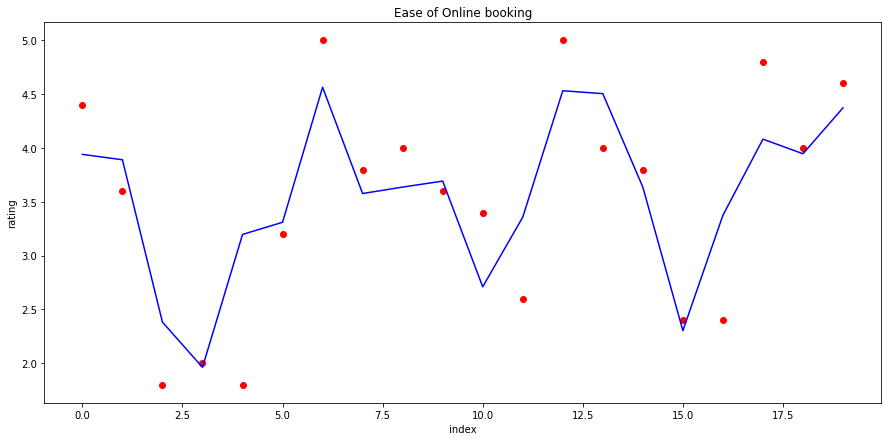

In [1555]:
best_feature = "Ease of Online booking"

plot_result(best_feature,pred1)

As we can see the model did a better results predicting the values. (more scattered points intersects with the line)

**DecisionTree**

In [1482]:
from sklearn.tree import DecisionTreeRegressor

0- Feature: Gender_Male, Score: 0.006230236
1- Feature: Customer Type_disloyal Customer, Score: 0.029079890
2- Feature: Type of Travel_Personal Travel, Score: 0.039257718
3- Feature: Class_Eco, Score: 0.040439992
4- Feature: Class_Eco Plus, Score: 0.004984924
5- Feature: Arrival Delay in Minutes, Score: 0.022716102
6- Feature: Departure Delay in Minutes, Score: 0.019244817
7- Feature: Flight Distance, Score: 0.056256238
8- Feature: Age, Score: 0.043148338
9- Feature: Departure/Arrival time convenient, Score: 0.018542940
10- Feature: Ease of Online booking, Score: 0.186970503
11- Feature: Gate location, Score: 0.029785712
12- Feature: Food and drink, Score: 0.011261977
13- Feature: Inflight entertainment, Score: 0.368839792
14- Feature: On-board service, Score: 0.022417933
15- Feature: Baggage handling, Score: 0.031013728
16- Feature: Checkin service, Score: 0.042107779
17- Feature: Cleanliness, Score: 0.027701381


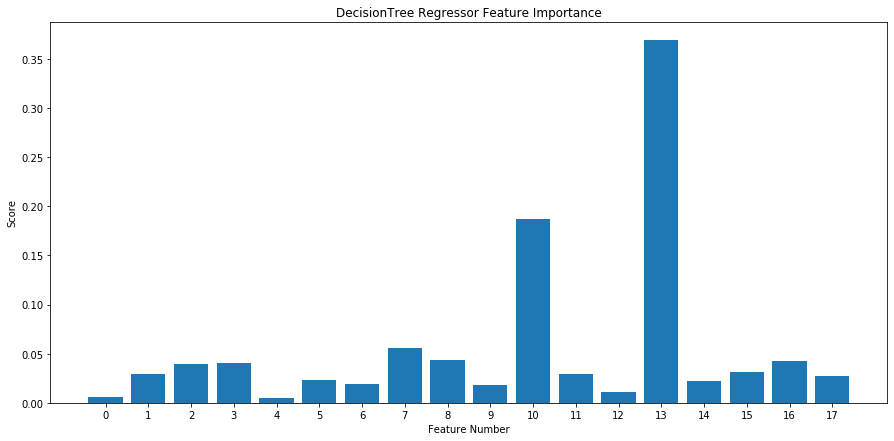

In [1483]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(new_X_train,new_Y_train)
pred3 = regressor.predict(new_X_test[:20])
regressor.score(new_X_train, new_Y_train)
importance = regressor.feature_importances_
model = "DecisionTree Regressor"
features_importance(importance,new_X_train,model)

Inflight entertainment feature got the highest value (most important) and Ease of Online booking comes second while the Class "feature" got the least important. 

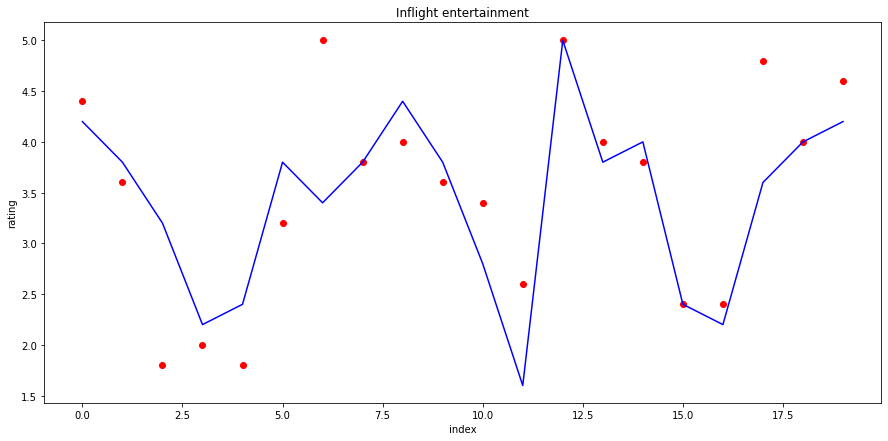

In [1484]:
best_feature = "Inflight entertainment"

plot_result(best_feature,pred3)

We can see that there are some scattered points intersecting with the line and it looks promising

Comparing the three regression models

<Figure size 432x288 with 0 Axes>

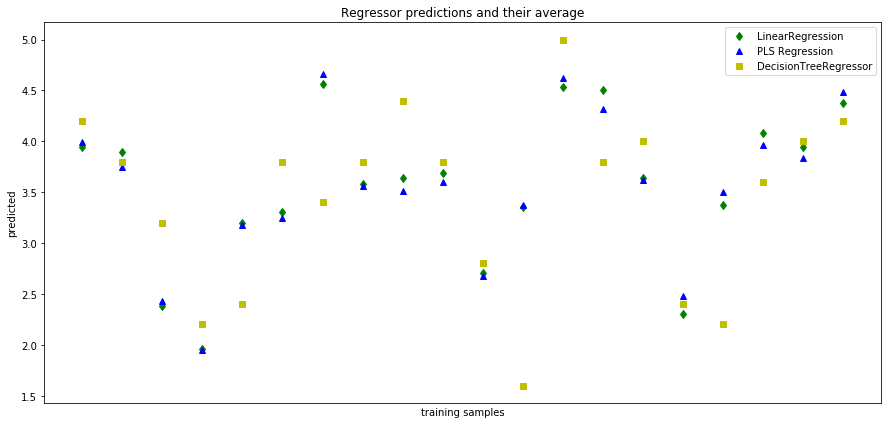

In [1556]:
plt.figure()
plt.figure(figsize=(15,7))

plt.plot(pred1[:50], 'gd', label='LinearRegression')
plt.plot(pred2[:50], 'b^', label='PLS Regression')
plt.plot(pred3[:50], 'ys', label='DecisionTreeRegressor')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

As we can see from the graph above, the PLS regressor has predicted similar results to LinearRegression and decisionTree seems to be predicting differently than the others.

 **We will now run the three models on the data where the features we grouped before are included**

**LinearRegression**

0- Feature: Gender_Male, Score: 0.000000000
1- Feature: Customer Type_disloyal Customer, Score: 0.000000000
2- Feature: Type of Travel_Personal Travel, Score: 0.000000000
3- Feature: Class_Eco, Score: -0.000000000
4- Feature: Class_Eco Plus, Score: -0.000000000
5- Feature: Arrival Delay in Minutes, Score: 0.000000000
6- Feature: Departure Delay in Minutes, Score: -0.000000000
7- Feature: Flight Distance, Score: 0.000000000
8- Feature: Age, Score: -0.000000000
9- Feature: Inflight wifi service, Score: 0.200000000
10- Feature: Departure/Arrival time convenient, Score: -0.000000000
11- Feature: Ease of Online booking, Score: 0.000000000
12- Feature: Gate location, Score: -0.000000000
13- Feature: Food and drink, Score: -0.000000000
14- Feature: Online boarding, Score: 0.200000000
15- Feature: Seat comfort, Score: 0.200000000
16- Feature: Inflight entertainment, Score: 0.000000000
17- Feature: On-board service, Score: -0.000000000
18- Feature: Leg room service, Score: 0.200000000
19- Featu

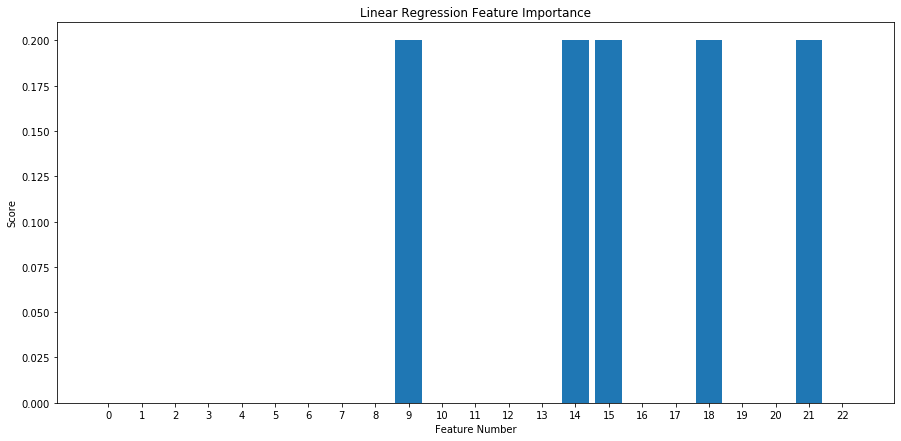

In [1487]:
reg = linear_model.LinearRegression()

reg.fit(normalized_X_train,new_Y_train)
pred4 = reg.predict(normalized_X_test[:20])
reg.score(normalized_X_train, new_Y_train)
importance = reg.coef_
model = "Linear Regression"
features_importance(importance,normalized_X_train,model)

This is quite surprising , the features we grouped as a new label got the same/best importance score and the rest got 0 score

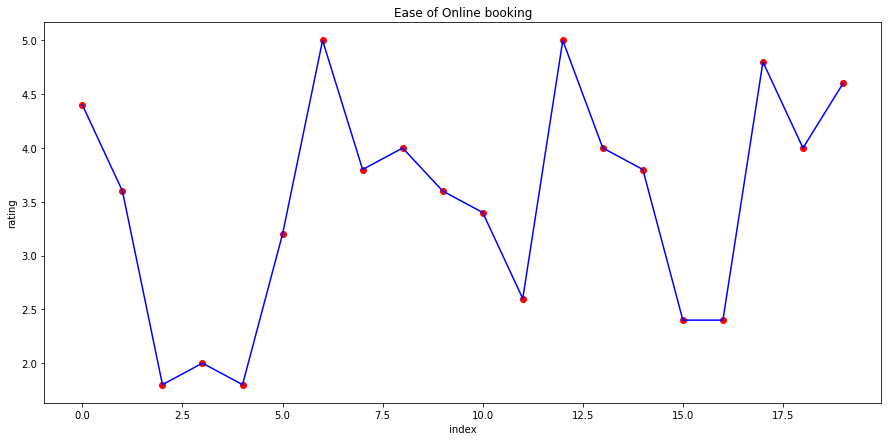

In [1489]:
best_feature = "Ease of Online booking"

plot_result(best_feature,pred4,normalized_X_test)

The predicted scattered points are perfectly aligned with the actual points/values which means that the model predicted the labels/values perfectly.

**PLSRegression**

In [1490]:
pls_reg = PLSRegression(n_components=2)
pls_reg.fit(normalized_X_train,new_Y_train)
pred5 = pls_reg.predict(normalized_X_test[:20])
pls_reg.score(normalized_X_train,new_Y_train)
model = "PLSRegression"
importance = pls_reg.coef_

In [1491]:
tmp_imp = []
for ind,val in enumerate(importance): tmp_imp.append(val[0])
importance = tmp_imp

0- Feature: Gender_Male, Score: -0.005723925
1- Feature: Customer Type_disloyal Customer, Score: -0.010764246
2- Feature: Type of Travel_Personal Travel, Score: -0.019770281
3- Feature: Class_Eco, Score: -0.013204837
4- Feature: Class_Eco Plus, Score: -0.016494703
5- Feature: Arrival Delay in Minutes, Score: 0.002133908
6- Feature: Departure Delay in Minutes, Score: 0.002895948
7- Feature: Flight Distance, Score: -0.006923912
8- Feature: Age, Score: 0.013656301
9- Feature: Inflight wifi service, Score: 0.221582368
10- Feature: Departure/Arrival time convenient, Score: 0.019748554
11- Feature: Ease of Online booking, Score: 0.124221152
12- Feature: Gate location, Score: -0.000127809
13- Feature: Food and drink, Score: -0.001701967
14- Feature: Online boarding, Score: 0.231041040
15- Feature: Seat comfort, Score: 0.132554792
16- Feature: Inflight entertainment, Score: 0.064464028
17- Feature: On-board service, Score: 0.047587203
18- Feature: Leg room service, Score: 0.214784579
19- Featu

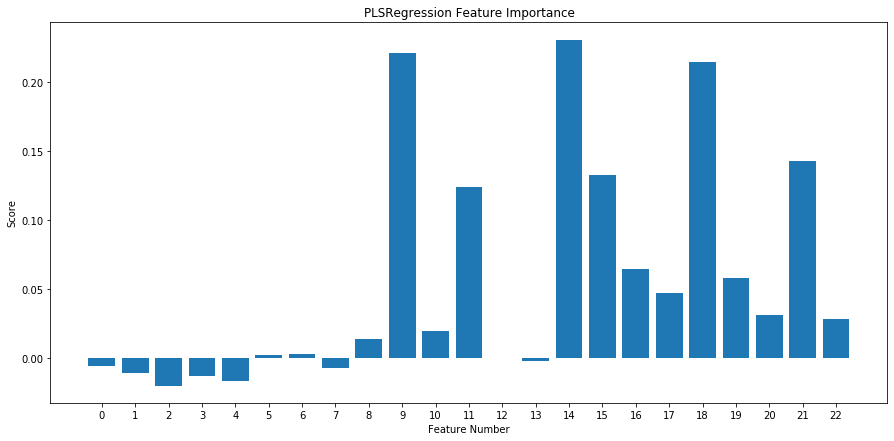

In [1492]:
features_importance(importance,normalized_X_train,model)

Unlike the linear regressor , PLS distributed the score values across all features with feature 14-Online boarding being with the heighest score and then 9 - Inflight wifi service comes second and eventually Type of Travel having the least score.(which we have seen before)

In [1493]:
best_feature = "Online boarding"

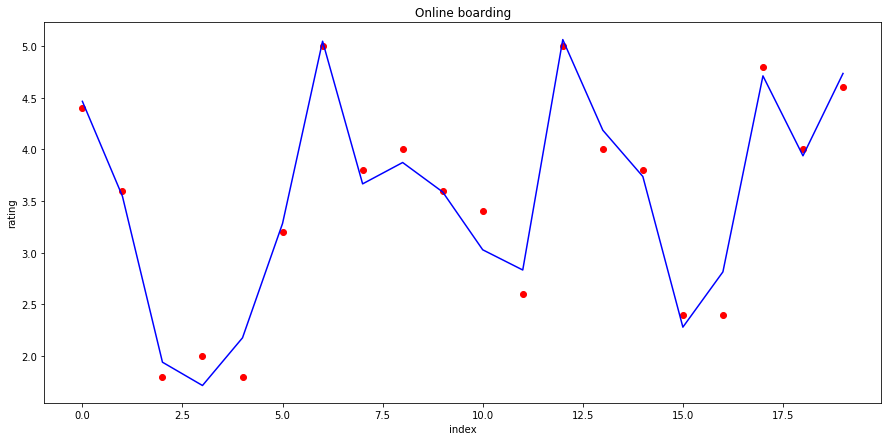

In [1494]:
plot_result(best_feature,pred5,normalized_X_test)

We can see that the scatterd points are similar/close to the actual points which means that the algorithm did a good job.

**DecisionTree**

0- Feature: Gender_Male, Score: 0.000006968
1- Feature: Customer Type_disloyal Customer, Score: 0.000007684
2- Feature: Type of Travel_Personal Travel, Score: 0.000014359
3- Feature: Class_Eco, Score: 0.000022807
4- Feature: Class_Eco Plus, Score: 0.000003951
5- Feature: Arrival Delay in Minutes, Score: 0.000034800
6- Feature: Departure Delay in Minutes, Score: 0.000030827
7- Feature: Flight Distance, Score: 0.000109442
8- Feature: Age, Score: 0.000078228
9- Feature: Inflight wifi service, Score: 0.180554636
10- Feature: Departure/Arrival time convenient, Score: 0.000047876
11- Feature: Ease of Online booking, Score: 0.000735589
12- Feature: Gate location, Score: 0.000206212
13- Feature: Food and drink, Score: 0.000032574
14- Feature: Online boarding, Score: 0.428844294
15- Feature: Seat comfort, Score: 0.101442830
16- Feature: Inflight entertainment, Score: 0.000504319
17- Feature: On-board service, Score: 0.000039505
18- Feature: Leg room service, Score: 0.198520556
19- Feature: Bagg

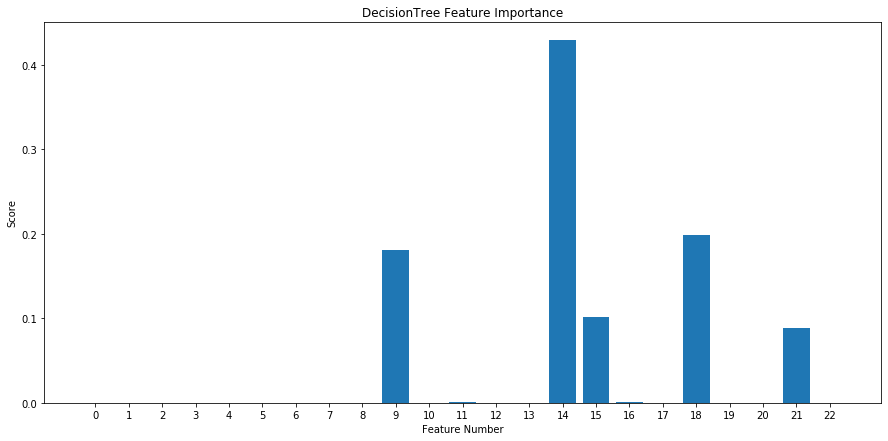

In [1495]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(normalized_X_train,new_Y_train)
pred6 = regressor.predict(normalized_X_test[:20])
regressor.score(normalized_X_train, new_Y_train)
importance = regressor.feature_importances_
model = "DecisionTree"
features_importance(importance,normalized_X_train,model)

Feature 14 - Online boarding got the highest score and then 18 - Leg room service comes in second and eventually feature Inflight entertainment got the lowest score.

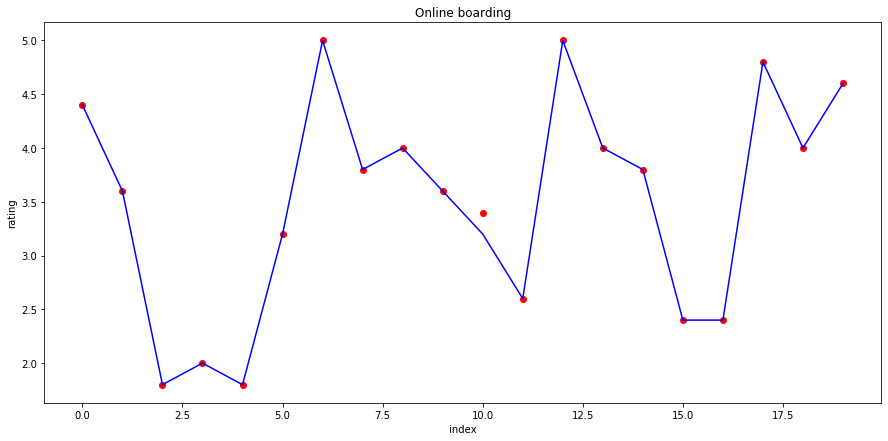

In [1547]:
best_feature = "Online boarding"

plot_result(best_feature,pred6,normalized_X_test)

we can see that the scattered points are almost perfectlly aligned on the line (besides one scattered point but its close)

<Figure size 432x288 with 0 Axes>

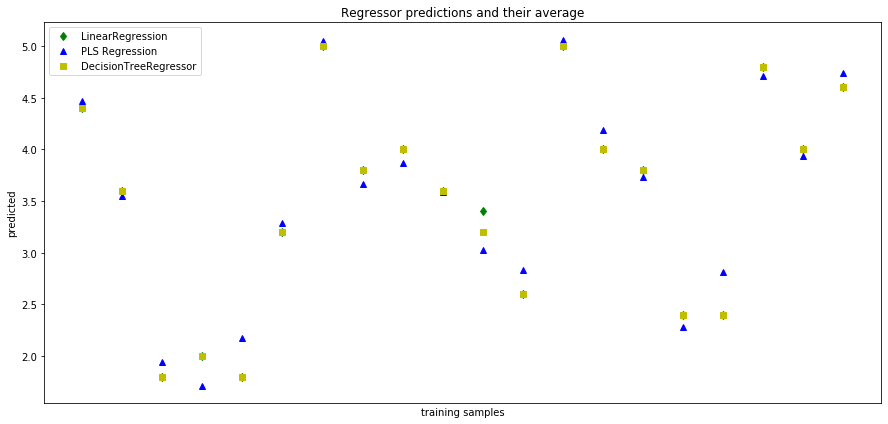

In [1549]:
plt.figure()
plt.figure(figsize=(15,7))

plt.plot(pred4[:50], 'gd', label='LinearRegression')
plt.plot(pred5[:50], 'b^', label='PLS Regression')
plt.plot(pred6[:50], 'ys', label='DecisionTreeRegressor')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

As we can see from the graphs - comparing the 3 models we conclude the following:
- DecisionTreeRegressor and LinearRegression overlap/very close together for almost all the points which means they give us similar results while PLS Regression seems to be quite different.